In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

C:\Users\User\AppData\Local\Temp\ipykernel_417984\2715139792.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.42725031 0.69695044 0.32924264 ... 0.33095551 0.77165354 0.50924784]
 [0.45745993 0.51683609 0.42215989 ... 0.33095551 0.77165354 0.52342787]
 [0.43218249 0.62674714 0.3411641  ... 0.33095551 0.77165354 0.48766954]
 ...
 [0.47102343 0.46473952 0.46949509 ... 0.33095551 0.77165354 0.55487053]
 [0.43464858 0.51620076 0.3997195  ... 0.33095551 0.77165354 0.52959309]
 [0.44389642 0.52414231 0.42356241 ... 0.33095551 0.77165354 0.47040691]]
Fold 2:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.43464858 0.62313675 0.34639831 ... 0.33095551 0.77165354 0.48705302]
 [0.42725031 0.71548931 0.32450565 ... 0.33095551 0.77165354 0.50924784]
 [0.45745993 0.53175632 0.4180791  ... 0.33095551 0.77165354 0.52342787]
 ...
 [0.47102343 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-15 20:32:45,942] A new study created in memory with name: no-name-8edf3100-3684-4d17-b473-a9e52681d641
[I 2025-05-15 20:39:59,517] Trial 0 finished with value: 0.026720007136464118 and parameters: {'lr': 0.018251123355942644, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13464062438565014}. Best is trial 0 with value: 0.026720007136464118.


Cross Validation Accuracies:
[0.028155984356999397, 0.02358257584273815, 0.02915758080780506, 0.0334295779466629, 0.019274316728115082]
Mean Cross Validation Accuracy:
0.026720007136464118
Standard Deviation of Cross Validation Accuracy:
0.004864235134489577


[I 2025-05-15 20:52:39,952] Trial 1 finished with value: 0.28097553700208666 and parameters: {'lr': 0.013079479066707225, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.35888305743467563}. Best is trial 0 with value: 0.026720007136464118.


Cross Validation Accuracies:
[0.3780902624130249, 0.12677480280399323, 0.09274648874998093, 0.571966290473938, 0.23529984056949615]
Mean Cross Validation Accuracy:
0.28097553700208666
Standard Deviation of Cross Validation Accuracy:
0.1762958869488931


[I 2025-05-15 21:07:25,680] Trial 2 finished with value: 0.11551092565059662 and parameters: {'lr': 0.003096406116258146, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3485669707484656}. Best is trial 0 with value: 0.026720007136464118.


Cross Validation Accuracies:
[0.11662010848522186, 0.12708178162574768, 0.11466289311647415, 0.10979997366666794, 0.10938987135887146]
Mean Cross Validation Accuracy:
0.11551092565059662
Standard Deviation of Cross Validation Accuracy:
0.006417420540096035


[I 2025-05-15 21:20:32,178] Trial 3 finished with value: 1.4025146484375 and parameters: {'lr': 0.025064810795312042, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3319286527096996}. Best is trial 0 with value: 0.026720007136464118.


Cross Validation Accuracies:
[0.7192897200584412, 0.7144815325737, 2.3888320922851562, 0.6879242658615112, 2.5020456314086914]
Mean Cross Validation Accuracy:
1.4025146484375
Standard Deviation of Cross Validation Accuracy:
0.8523632756877417


[I 2025-05-15 21:32:04,691] Trial 4 finished with value: 0.024163579940795897 and parameters: {'lr': 0.006673135949282164, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18413316907052174}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.020016297698020935, 0.022615797817707062, 0.02755562588572502, 0.031348492950201035, 0.01928168535232544]
Mean Cross Validation Accuracy:
0.024163579940795897
Standard Deviation of Cross Validation Accuracy:
0.004616436394448782


[I 2025-05-15 21:44:47,583] Trial 5 finished with value: 0.046747556701302526 and parameters: {'lr': 0.01265708592352563, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4775611806393901}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.04939359053969383, 0.031410057097673416, 0.03110247664153576, 0.051550623029470444, 0.07028103619813919]
Mean Cross Validation Accuracy:
0.046747556701302526
Standard Deviation of Cross Validation Accuracy:
0.01458700121767705


[I 2025-05-15 21:56:07,350] Trial 6 finished with value: 0.024448028951883315 and parameters: {'lr': 0.0020066770347250957, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19629337255276913}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.01818547584116459, 0.023156629875302315, 0.02754446119070053, 0.033760249614715576, 0.01959332823753357]
Mean Cross Validation Accuracy:
0.024448028951883315
Standard Deviation of Cross Validation Accuracy:
0.00567028655974884


[I 2025-05-15 22:10:12,652] Trial 7 finished with value: 0.05150162354111672 and parameters: {'lr': 0.002496971928873386, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12351372285364609}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.05217494070529938, 0.05821127071976662, 0.042016517370939255, 0.05513954535126686, 0.04996584355831146]
Mean Cross Validation Accuracy:
0.05150162354111672
Standard Deviation of Cross Validation Accuracy:
0.005496054140516403


[I 2025-05-15 22:21:45,341] Trial 8 finished with value: 0.04910759180784226 and parameters: {'lr': 0.0013947140263078461, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.48011677603373304}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.03821195662021637, 0.0782938152551651, 0.058576520532369614, 0.03745514899492264, 0.03300051763653755]
Mean Cross Validation Accuracy:
0.04910759180784226
Standard Deviation of Cross Validation Accuracy:
0.01706123312259311


[I 2025-05-15 22:36:16,002] Trial 9 finished with value: 0.0685873918235302 and parameters: {'lr': 0.003266839237613504, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3987747815759223}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.054970625787973404, 0.07710987329483032, 0.07483518123626709, 0.07592795789241791, 0.06009332090616226]
Mean Cross Validation Accuracy:
0.0685873918235302
Standard Deviation of Cross Validation Accuracy:
0.009199098121040297


[I 2025-05-15 22:50:48,947] Trial 10 finished with value: 0.12118434607982635 and parameters: {'lr': 0.24835736596684635, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2367763189418638}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.1177736222743988, 0.11998781561851501, 0.12136363238096237, 0.1298951506614685, 0.11690150946378708]
Mean Cross Validation Accuracy:
0.12118434607982635
Standard Deviation of Cross Validation Accuracy:
0.004632875382282062


[I 2025-05-15 23:02:47,351] Trial 11 finished with value: 0.055149363726377486 and parameters: {'lr': 0.08680583859083885, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21439612962437504}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.04984523355960846, 0.05613037571310997, 0.05488176643848419, 0.0606122650206089, 0.05427717790007591]
Mean Cross Validation Accuracy:
0.055149363726377486
Standard Deviation of Cross Validation Accuracy:
0.0034575074350967497


[I 2025-05-15 23:15:20,390] Trial 12 finished with value: 0.02438250221312046 and parameters: {'lr': 0.006185281190876904, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21391973929581995}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.02297341078519821, 0.022219981998205185, 0.027819545939564705, 0.031399257481098175, 0.017500314861536026]
Mean Cross Validation Accuracy:
0.02438250221312046
Standard Deviation of Cross Validation Accuracy:
0.004797388021468614


[I 2025-05-15 23:25:56,096] Trial 13 finished with value: 0.02461439333856106 and parameters: {'lr': 0.008731766592303077, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.25309562744149317}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.023887233808636665, 0.02266407199203968, 0.02739199437201023, 0.030966920778155327, 0.018161745741963387]
Mean Cross Validation Accuracy:
0.02461439333856106
Standard Deviation of Cross Validation Accuracy:
0.004336792540907406


[I 2025-05-15 23:36:47,793] Trial 14 finished with value: 0.4986925423145294 and parameters: {'lr': 0.9863774568804055, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16631968920309695}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.4918535351753235, 0.5062650442123413, 0.5034032464027405, 0.4982306659221649, 0.4937102198600769]
Mean Cross Validation Accuracy:
0.4986925423145294
Standard Deviation of Cross Validation Accuracy:
0.005501679806952204


[I 2025-05-15 23:49:10,741] Trial 15 finished with value: 0.034120474383234976 and parameters: {'lr': 0.05888843993157826, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.285074241513108}. Best is trial 4 with value: 0.024163579940795897.


Cross Validation Accuracies:
[0.026297204196453094, 0.027553560212254524, 0.03430614620447159, 0.04379505291581154, 0.03865040838718414]
Mean Cross Validation Accuracy:
0.034120474383234976
Standard Deviation of Cross Validation Accuracy:
0.006610297482454804


[I 2025-05-16 00:00:19,038] Trial 16 finished with value: 0.023806383833289146 and parameters: {'lr': 0.006296175153763991, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10176097300546696}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.018780112266540527, 0.022403137758374214, 0.0284016914665699, 0.030678750947117805, 0.018768226727843285]
Mean Cross Validation Accuracy:
0.023806383833289146
Standard Deviation of Cross Validation Accuracy:
0.004918573256958697


[I 2025-05-16 00:12:21,446] Trial 17 finished with value: 0.03781612366437912 and parameters: {'lr': 0.053732780937058494, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15638180407133406}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.03314320370554924, 0.044601041823625565, 0.03597186133265495, 0.04241153225302696, 0.03295297920703888]
Mean Cross Validation Accuracy:
0.03781612366437912
Standard Deviation of Cross Validation Accuracy:
0.0048174796943442726


[I 2025-05-16 00:26:36,612] Trial 18 finished with value: 0.04589229896664619 and parameters: {'lr': 0.00563428731716517, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11467684427231034}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.050867799669504166, 0.046899281442165375, 0.0541209802031517, 0.04068595543503761, 0.036887478083372116]
Mean Cross Validation Accuracy:
0.04589229896664619
Standard Deviation of Cross Validation Accuracy:
0.0063509625719434405


[I 2025-05-16 00:38:31,312] Trial 19 finished with value: 0.026169510185718538 and parameters: {'lr': 0.004660007347115802, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10018650159526953}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.024872275069355965, 0.02323458343744278, 0.029600834473967552, 0.03343673422932625, 0.019703123718500137]
Mean Cross Validation Accuracy:
0.026169510185718538
Standard Deviation of Cross Validation Accuracy:
0.004831093035316369


[I 2025-05-16 00:52:07,724] Trial 20 finished with value: 0.024856939911842346 and parameters: {'lr': 0.0011253044150582312, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17345108131911466}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.020269013941287994, 0.02300187200307846, 0.028356196358799934, 0.03344569727778435, 0.019211919978260994]
Mean Cross Validation Accuracy:
0.024856939911842346
Standard Deviation of Cross Validation Accuracy:
0.00533606859926933


[I 2025-05-16 01:06:41,044] Trial 21 finished with value: 0.024678562581539155 and parameters: {'lr': 0.007550066639270784, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2623895563378027}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.021089082583785057, 0.02233421429991722, 0.029247255995869637, 0.031466443091630936, 0.01925581693649292]
Mean Cross Validation Accuracy:
0.024678562581539155
Standard Deviation of Cross Validation Accuracy:
0.004790298261781179


[I 2025-05-16 01:18:49,460] Trial 22 finished with value: 0.028325402364134788 and parameters: {'lr': 0.031966109299927346, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.20453300716679457}. Best is trial 16 with value: 0.023806383833289146.


Cross Validation Accuracies:
[0.022187156602740288, 0.025187917053699493, 0.04318248853087425, 0.03360123187303543, 0.017468217760324478]
Mean Cross Validation Accuracy:
0.028325402364134788
Standard Deviation of Cross Validation Accuracy:
0.009099095768202446


[I 2025-05-16 01:30:37,243] Trial 23 finished with value: 0.02344258241355419 and parameters: {'lr': 0.006057804625644844, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1564759717828334}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.01739099621772766, 0.023007573559880257, 0.028359418734908104, 0.02928946167230606, 0.019165461882948875]
Mean Cross Validation Accuracy:
0.02344258241355419
Standard Deviation of Cross Validation Accuracy:
0.00476373728702636


[I 2025-05-16 01:43:25,155] Trial 24 finished with value: 0.023950100317597388 and parameters: {'lr': 0.012005906093673078, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15871434057886247}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.018144801259040833, 0.0227640513330698, 0.029493071138858795, 0.03116193227469921, 0.018186645582318306]
Mean Cross Validation Accuracy:
0.023950100317597388
Standard Deviation of Cross Validation Accuracy:
0.0054965564773122805


[I 2025-05-16 01:56:16,649] Trial 25 finished with value: 0.032001597434282304 and parameters: {'lr': 0.028644029316934556, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13840644671142516}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.034411005675792694, 0.02291671186685562, 0.03509557992219925, 0.033762168139219284, 0.033822521567344666]
Mean Cross Validation Accuracy:
0.032001597434282304
Standard Deviation of Cross Validation Accuracy:
0.004567898759571708


[I 2025-05-16 02:09:10,869] Trial 26 finished with value: 0.025194884091615678 and parameters: {'lr': 0.011449519126734545, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1576339420113602}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.020712075755000114, 0.026458708569407463, 0.027765987440943718, 0.03177915886044502, 0.019258489832282066]
Mean Cross Validation Accuracy:
0.025194884091615678
Standard Deviation of Cross Validation Accuracy:
0.004623783004426426


[I 2025-05-16 02:23:00,332] Trial 27 finished with value: 0.09894655495882035 and parameters: {'lr': 0.20750570893501716, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13782921624186678}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.10084118694067001, 0.09072916209697723, 0.10035507380962372, 0.10438594222068787, 0.09842140972614288]
Mean Cross Validation Accuracy:
0.09894655495882035
Standard Deviation of Cross Validation Accuracy:
0.004537880836812635


[I 2025-05-16 02:34:13,347] Trial 28 finished with value: 0.08825081400573254 and parameters: {'lr': 0.004042556913728413, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10574427024410565}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.22967876493930817, 0.029588086530566216, 0.05295410007238388, 0.09888899326324463, 0.03014412522315979]
Mean Cross Validation Accuracy:
0.08825081400573254
Standard Deviation of Cross Validation Accuracy:
0.07507142872461918


[I 2025-05-16 02:47:18,064] Trial 29 finished with value: 0.09160718023777008 and parameters: {'lr': 0.02036224515409174, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.302364259198774}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.05432913452386856, 0.05796591937541962, 0.05646350234746933, 0.13665923476219177, 0.15261811017990112]
Mean Cross Validation Accuracy:
0.09160718023777008
Standard Deviation of Cross Validation Accuracy:
0.043608454248204545


[I 2025-05-16 02:59:26,091] Trial 30 finished with value: 0.02576112262904644 and parameters: {'lr': 0.015694221084742967, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15022821509904943}. Best is trial 23 with value: 0.02344258241355419.


Cross Validation Accuracies:
[0.01793762296438217, 0.024639379233121872, 0.03022751770913601, 0.03331073373556137, 0.022690359503030777]
Mean Cross Validation Accuracy:
0.02576112262904644
Standard Deviation of Cross Validation Accuracy:
0.005456012358792119


[I 2025-05-16 03:10:33,995] Trial 31 finished with value: 0.022642381861805914 and parameters: {'lr': 0.008336220684587906, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18235511729380205}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.017035355791449547, 0.021283045411109924, 0.026376014575362206, 0.030426738783717155, 0.018090754747390747]
Mean Cross Validation Accuracy:
0.022642381861805914
Standard Deviation of Cross Validation Accuracy:
0.0050703071357851934


[I 2025-05-16 03:20:59,145] Trial 32 finished with value: 0.024911557137966157 and parameters: {'lr': 0.0099091279637704, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12446413022723067}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.017111537978053093, 0.03175880014896393, 0.02798496000468731, 0.03011588379740715, 0.0175866037607193]
Mean Cross Validation Accuracy:
0.024911557137966157
Standard Deviation of Cross Validation Accuracy:
0.006291435430565062


[I 2025-05-16 03:33:34,291] Trial 33 finished with value: 0.024603144079446793 and parameters: {'lr': 0.0019123003363176855, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1806537798766423}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.020311469212174416, 0.02288649044930935, 0.028624456375837326, 0.032151173800230026, 0.019042130559682846]
Mean Cross Validation Accuracy:
0.024603144079446793
Standard Deviation of Cross Validation Accuracy:
0.005008671469964217


[I 2025-05-16 03:46:12,709] Trial 34 finished with value: 0.02384921573102474 and parameters: {'lr': 0.015449467931565678, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2287260876374293}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.018281051889061928, 0.02255764976143837, 0.02996201440691948, 0.03151858597993851, 0.016926776617765427]
Mean Cross Validation Accuracy:
0.02384921573102474
Standard Deviation of Cross Validation Accuracy:
0.005946062599207346


[I 2025-05-16 03:56:46,697] Trial 35 finished with value: 0.0423638716340065 and parameters: {'lr': 0.018374203189983822, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22409122201987028}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.04185625910758972, 0.044874489307403564, 0.045058052986860275, 0.04557797685265541, 0.03445257991552353]
Mean Cross Validation Accuracy:
0.0423638716340065
Standard Deviation of Cross Validation Accuracy:
0.004165056872420767


[I 2025-05-16 04:08:09,430] Trial 36 finished with value: 0.029231172427535056 and parameters: {'lr': 0.04024060421681063, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.24808431830065825}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.02762645296752453, 0.023339075967669487, 0.028593676164746284, 0.03800336271524429, 0.028593294322490692]
Mean Cross Validation Accuracy:
0.029231172427535056
Standard Deviation of Cross Validation Accuracy:
0.0047970102698126835


[I 2025-05-16 04:20:01,731] Trial 37 finished with value: 0.04007382355630398 and parameters: {'lr': 0.0030342773245550887, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19012614961252522}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.031029826030135155, 0.048881594091653824, 0.028583426028490067, 0.044739119708538055, 0.04713515192270279]
Mean Cross Validation Accuracy:
0.04007382355630398
Standard Deviation of Cross Validation Accuracy:
0.008520883697012597


[I 2025-05-16 04:31:47,468] Trial 38 finished with value: 0.024694918468594552 and parameters: {'lr': 0.0048374078784081094, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3930431099211734}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.019570551812648773, 0.023387474939227104, 0.028636282309889793, 0.033020712435245514, 0.01885957084596157]
Mean Cross Validation Accuracy:
0.024694918468594552
Standard Deviation of Cross Validation Accuracy:
0.005419834281389298


[I 2025-05-16 04:41:42,367] Trial 39 finished with value: 0.028708737716078757 and parameters: {'lr': 0.007432974923317512, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2766272077538961}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.020563703030347824, 0.028669951483607292, 0.030260056257247925, 0.03594246134161949, 0.02810751646757126]
Mean Cross Validation Accuracy:
0.028708737716078757
Standard Deviation of Cross Validation Accuracy:
0.004928243259014872


[I 2025-05-16 04:54:32,272] Trial 40 finished with value: 0.3974026918411255 and parameters: {'lr': 0.015495113945681259, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23157487512900024}. Best is trial 31 with value: 0.022642381861805914.


Cross Validation Accuracies:
[0.4154468774795532, 0.38593265414237976, 0.43458855152130127, 0.3998229205608368, 0.3512224555015564]
Mean Cross Validation Accuracy:
0.3974026918411255
Standard Deviation of Cross Validation Accuracy:
0.02820785101971643


[I 2025-05-16 05:07:04,147] Trial 41 finished with value: 0.022514081001281737 and parameters: {'lr': 0.009088467459621183, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1391807595329052}. Best is trial 41 with value: 0.022514081001281737.


Cross Validation Accuracies:
[0.01747421734035015, 0.022246619686484337, 0.02633092924952507, 0.029123349115252495, 0.01739528961479664]
Mean Cross Validation Accuracy:
0.022514081001281737
Standard Deviation of Cross Validation Accuracy:
0.0046888067157116785


[I 2025-05-16 05:19:50,619] Trial 42 finished with value: 0.022255120053887367 and parameters: {'lr': 0.009777828608836353, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1312852896295042}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.016228627413511276, 0.022138254716992378, 0.02682165428996086, 0.029974306002259254, 0.016112757846713066]
Mean Cross Validation Accuracy:
0.022255120053887367
Standard Deviation of Cross Validation Accuracy:
0.0055587759654508705


[I 2025-05-16 05:31:52,619] Trial 43 finished with value: 0.024641242995858192 and parameters: {'lr': 0.0019170980704825795, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13375246121606116}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.019933272153139114, 0.022682245820760727, 0.0283029954880476, 0.03337664157152176, 0.018911059945821762]
Mean Cross Validation Accuracy:
0.024641242995858192
Standard Deviation of Cross Validation Accuracy:
0.005450748146165223


[I 2025-05-16 05:43:11,293] Trial 44 finished with value: 0.02422654628753662 and parameters: {'lr': 0.004054303141540564, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12304277939779548}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.020955244079232216, 0.022105755284428596, 0.027460811659693718, 0.03253631666302681, 0.018074603751301765]
Mean Cross Validation Accuracy:
0.02422654628753662
Standard Deviation of Cross Validation Accuracy:
0.005148947965885183


[I 2025-05-16 05:53:44,177] Trial 45 finished with value: 0.02325342521071434 and parameters: {'lr': 0.008843461521157635, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14166316953656938}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01814935728907585, 0.021640900522470474, 0.026935702189803123, 0.029499363154172897, 0.020041802898049355]
Mean Cross Validation Accuracy:
0.02325342521071434
Standard Deviation of Cross Validation Accuracy:
0.004278718678351385


[I 2025-05-16 06:06:37,341] Trial 46 finished with value: 0.02474098764359951 and parameters: {'lr': 0.002594102532492187, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.18975796308620957}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.020598826929926872, 0.023186223581433296, 0.028094720095396042, 0.03281030431389809, 0.019014863297343254]
Mean Cross Validation Accuracy:
0.02474098764359951
Standard Deviation of Cross Validation Accuracy:
0.005073946778977425


[I 2025-05-16 06:16:49,560] Trial 47 finished with value: 0.02289152704179287 and parameters: {'lr': 0.008821079749673534, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14505128618111485}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01661747880280018, 0.02195020392537117, 0.02722361497581005, 0.030798405408859253, 0.017867932096123695]
Mean Cross Validation Accuracy:
0.02289152704179287
Standard Deviation of Cross Validation Accuracy:
0.005417969879438416


[I 2025-05-16 06:27:38,243] Trial 48 finished with value: 0.03143945634365082 and parameters: {'lr': 0.01004886965860998, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.17612905553261327}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.02430024743080139, 0.03578321263194084, 0.03867657482624054, 0.02995978482067585, 0.028477462008595467]
Mean Cross Validation Accuracy:
0.03143945634365082
Standard Deviation of Cross Validation Accuracy:
0.005160915515317271


[I 2025-05-16 06:36:58,927] Trial 49 finished with value: 0.09132171869277954 and parameters: {'lr': 0.02084199964191865, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14217275031378643}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.06402654945850372, 0.05380652844905853, 0.1401255577802658, 0.1286575347185135, 0.06999242305755615]
Mean Cross Validation Accuracy:
0.09132171869277954
Standard Deviation of Cross Validation Accuracy:
0.03572991039123888


[I 2025-05-16 06:46:35,444] Trial 50 finished with value: 0.025397911295294763 and parameters: {'lr': 0.007812075644476163, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3349218965119267}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01977202109992504, 0.024008898064494133, 0.02755109779536724, 0.03181317821145058, 0.023844361305236816]
Mean Cross Validation Accuracy:
0.025397911295294763
Standard Deviation of Cross Validation Accuracy:
0.004044388149693921


[I 2025-05-16 06:58:29,506] Trial 51 finished with value: 0.024634794145822526 and parameters: {'lr': 0.0036862550206161497, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12181233976905081}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.020416563376784325, 0.022844873368740082, 0.028273917734622955, 0.0328700989484787, 0.018768517300486565]
Mean Cross Validation Accuracy:
0.024634794145822526
Standard Deviation of Cross Validation Accuracy:
0.005224441729456506


[I 2025-05-16 07:09:44,273] Trial 52 finished with value: 0.02319559007883072 and parameters: {'lr': 0.005858362192127851, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16559514700404496}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01805822364985943, 0.022005239501595497, 0.0280370581895113, 0.030834192410111427, 0.017043236643075943]
Mean Cross Validation Accuracy:
0.02319559007883072
Standard Deviation of Cross Validation Accuracy:
0.00543045081301494


[I 2025-05-16 07:20:42,683] Trial 53 finished with value: 0.025135566666722297 and parameters: {'lr': 0.008937655023531431, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4539022842450512}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.017391767352819443, 0.023534774780273438, 0.030550647526979446, 0.03344646468758583, 0.02075417898595333]
Mean Cross Validation Accuracy:
0.025135566666722297
Standard Deviation of Cross Validation Accuracy:
0.006001993787454859


[I 2025-05-16 07:30:57,407] Trial 54 finished with value: 0.023994932323694228 and parameters: {'lr': 0.005075620627002492, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1978736212593879}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.019711922854185104, 0.0220649316906929, 0.02801608294248581, 0.03290689364075661, 0.017274830490350723]
Mean Cross Validation Accuracy:
0.023994932323694228
Standard Deviation of Cross Validation Accuracy:
0.0057065146635336215


[I 2025-05-16 07:40:39,608] Trial 55 finished with value: 0.025240210443735124 and parameters: {'lr': 0.013216515405019716, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14463353709921745}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.016541728749871254, 0.025301020592451096, 0.02726191096007824, 0.030198194086551666, 0.026898197829723358]
Mean Cross Validation Accuracy:
0.025240210443735124
Standard Deviation of Cross Validation Accuracy:
0.004627852171471907


[I 2025-05-16 07:50:41,525] Trial 56 finished with value: 0.02449003644287586 and parameters: {'lr': 0.006997151845621663, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.17299108876383062}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.021076980978250504, 0.022564714774489403, 0.027832329273223877, 0.030541889369487762, 0.020434267818927765]
Mean Cross Validation Accuracy:
0.02449003644287586
Standard Deviation of Cross Validation Accuracy:
0.0039900104128061135


[I 2025-05-16 08:00:47,521] Trial 57 finished with value: 0.03129175305366516 and parameters: {'lr': 0.023513665676256904, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.20821112560524696}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.03243061155080795, 0.02398882620036602, 0.028593802824616432, 0.03768495097756386, 0.03376057371497154]
Mean Cross Validation Accuracy:
0.03129175305366516
Standard Deviation of Cross Validation Accuracy:
0.004666406109446798


[I 2025-05-16 08:10:37,906] Trial 58 finished with value: 0.03386509940028191 and parameters: {'lr': 0.03474764152868988, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11494576622008176}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.031443338841199875, 0.02377723902463913, 0.04338416829705238, 0.0396699495613575, 0.031050801277160645]
Mean Cross Validation Accuracy:
0.03386509940028191
Standard Deviation of Cross Validation Accuracy:
0.006926168972004584


[I 2025-05-16 08:21:24,442] Trial 59 finished with value: 0.02444043233990669 and parameters: {'lr': 0.0029175216924096354, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16833863784542055}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.020316755399107933, 0.022427154704928398, 0.02874865010380745, 0.0322638601064682, 0.01844574138522148]
Mean Cross Validation Accuracy:
0.02444043233990669
Standard Deviation of Cross Validation Accuracy:
0.005229934613540776


[I 2025-05-16 08:31:14,175] Trial 60 finished with value: 0.4324540257453918 and parameters: {'lr': 0.8417777026170463, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.13098358246785255}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.4223370850086212, 0.4409753084182739, 0.4335681200027466, 0.4389490783214569, 0.4264405369758606]
Mean Cross Validation Accuracy:
0.4324540257453918
Standard Deviation of Cross Validation Accuracy:
0.007135176373768039


[I 2025-05-16 08:40:42,672] Trial 61 finished with value: 0.02404518164694309 and parameters: {'lr': 0.005838410742263091, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1574081544418762}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.02102910354733467, 0.022247938439249992, 0.0268474742770195, 0.03176657110452652, 0.018334820866584778]
Mean Cross Validation Accuracy:
0.02404518164694309
Standard Deviation of Cross Validation Accuracy:
0.004741470861086294


[I 2025-05-16 08:50:35,606] Trial 62 finished with value: 0.02303129993379116 and parameters: {'lr': 0.01122276652723968, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1492660196741294}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.0173923559486866, 0.020773230120539665, 0.026791982352733612, 0.02884628064930439, 0.021352650597691536]
Mean Cross Validation Accuracy:
0.02303129993379116
Standard Deviation of Cross Validation Accuracy:
0.004187389762613121


[I 2025-05-16 09:00:33,536] Trial 63 finished with value: 0.02349535785615444 and parameters: {'lr': 0.011323963166012247, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10532697214076014}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01774411089718342, 0.02142971009016037, 0.027557523921132088, 0.03079027682542801, 0.019955167546868324]
Mean Cross Validation Accuracy:
0.02349535785615444
Standard Deviation of Cross Validation Accuracy:
0.004890679413126899


[I 2025-05-16 09:09:41,085] Trial 64 finished with value: 0.023232542723417283 and parameters: {'lr': 0.008857150213563132, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14921465249885638}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01833612471818924, 0.022276265546679497, 0.027828959748148918, 0.02940109185874462, 0.018320271745324135]
Mean Cross Validation Accuracy:
0.023232542723417283
Standard Deviation of Cross Validation Accuracy:
0.004651834678555928


[I 2025-05-16 09:18:54,153] Trial 65 finished with value: 0.02379978112876415 and parameters: {'lr': 0.013825047829323702, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18478809743186694}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.02200918458402157, 0.021019363775849342, 0.028751129284501076, 0.028818828985095024, 0.018400399014353752]
Mean Cross Validation Accuracy:
0.02379978112876415
Standard Deviation of Cross Validation Accuracy:
0.0042378526119559124


[I 2025-05-16 09:28:50,812] Trial 66 finished with value: 0.03135780096054077 and parameters: {'lr': 0.025431623320737864, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16455984328736717}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.033905308693647385, 0.03412965312600136, 0.030881203711032867, 0.037935204803943634, 0.019937634468078613]
Mean Cross Validation Accuracy:
0.03135780096054077
Standard Deviation of Cross Validation Accuracy:
0.0061332299655305796


[I 2025-05-16 09:38:35,639] Trial 67 finished with value: 0.03740594610571861 and parameters: {'lr': 0.010564335401095378, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14994502348653643}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.03405981883406639, 0.038385383784770966, 0.03758735582232475, 0.04088570177555084, 0.03611147031188011]
Mean Cross Validation Accuracy:
0.03740594610571861
Standard Deviation of Cross Validation Accuracy:
0.0022791727654166405


[I 2025-05-16 09:47:04,375] Trial 68 finished with value: 0.0316999115049839 and parameters: {'lr': 0.0044207677362940985, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11321912019675012}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.03055649809539318, 0.026918964460492134, 0.042962320148944855, 0.03903215751051903, 0.019029617309570312]
Mean Cross Validation Accuracy:
0.0316999115049839
Standard Deviation of Cross Validation Accuracy:
0.008547571395607642


[I 2025-05-16 09:55:26,457] Trial 69 finished with value: 0.13040734082460403 and parameters: {'lr': 0.0064763577470449765, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2136512705374058}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.12968337535858154, 0.13315819203853607, 0.13273626565933228, 0.12267143279314041, 0.13378743827342987]
Mean Cross Validation Accuracy:
0.13040734082460403
Standard Deviation of Cross Validation Accuracy:
0.004117876421599386


[I 2025-05-16 10:04:21,121] Trial 70 finished with value: 0.02788938395678997 and parameters: {'lr': 0.017337905984291812, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18095743366545702}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.019542183727025986, 0.028402632102370262, 0.03152083605527878, 0.03682729974389076, 0.023153968155384064]
Mean Cross Validation Accuracy:
0.02788938395678997
Standard Deviation of Cross Validation Accuracy:
0.00608994451711742


[I 2025-05-16 10:13:03,829] Trial 71 finished with value: 0.023688313364982606 and parameters: {'lr': 0.008365127344163935, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13692114971405003}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.021074024960398674, 0.022740304470062256, 0.02574797347187996, 0.03012578934431076, 0.018753474578261375]
Mean Cross Validation Accuracy:
0.023688313364982606
Standard Deviation of Cross Validation Accuracy:
0.003943834563429094


[I 2025-05-16 10:23:44,877] Trial 72 finished with value: 0.02425922453403473 and parameters: {'lr': 0.00880699708141668, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15114000052557436}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.020752234384417534, 0.021719105541706085, 0.027886154130101204, 0.03190884739160538, 0.019029781222343445]
Mean Cross Validation Accuracy:
0.02425922453403473
Standard Deviation of Cross Validation Accuracy:
0.004853238298554558


[I 2025-05-16 10:32:38,648] Trial 73 finished with value: 0.02252452224493027 and parameters: {'lr': 0.012058352832878018, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12657096297645584}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.016131116077303886, 0.02506319433450699, 0.024832673370838165, 0.029318271204829216, 0.01727735623717308]
Mean Cross Validation Accuracy:
0.02252452224493027
Standard Deviation of Cross Validation Accuracy:
0.005026645721865811


[I 2025-05-16 10:40:24,164] Trial 74 finished with value: 0.02276647202670574 and parameters: {'lr': 0.01296658039370071, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12963585033782754}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01731068454682827, 0.021544894203543663, 0.02711360901594162, 0.030575765296816826, 0.01728740707039833]
Mean Cross Validation Accuracy:
0.02276647202670574
Standard Deviation of Cross Validation Accuracy:
0.0053133922042486225


[I 2025-05-16 10:48:20,259] Trial 75 finished with value: 0.02666696049273014 and parameters: {'lr': 0.01357215390563772, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12654345627968352}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.028231818228960037, 0.024780265986919403, 0.031451575458049774, 0.031414199620485306, 0.017456943169236183]
Mean Cross Validation Accuracy:
0.02666696049273014
Standard Deviation of Cross Validation Accuracy:
0.005220376130019829


[I 2025-05-16 10:55:04,565] Trial 76 finished with value: 0.02348875030875206 and parameters: {'lr': 0.005750455314097424, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11348425223356827}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01994159445166588, 0.021886998787522316, 0.027175458148121834, 0.03079083003103733, 0.01764887012541294]
Mean Cross Validation Accuracy:
0.02348875030875206
Standard Deviation of Cross Validation Accuracy:
0.004820047844772079


[I 2025-05-16 11:03:14,432] Trial 77 finished with value: 0.02476644702255726 and parameters: {'lr': 0.01154073810110726, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16479849602161853}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01679685153067112, 0.022118134424090385, 0.02767927758395672, 0.031485896557569504, 0.025752075016498566]
Mean Cross Validation Accuracy:
0.02476644702255726
Standard Deviation of Cross Validation Accuracy:
0.00500270043874166


[I 2025-05-16 11:09:24,062] Trial 78 finished with value: 0.03344980850815773 and parameters: {'lr': 0.020376013384424577, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19895845606396428}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.028290338814258575, 0.02754020504653454, 0.03057648055255413, 0.04254458099603653, 0.03829743713140488]
Mean Cross Validation Accuracy:
0.03344980850815773
Standard Deviation of Cross Validation Accuracy:
0.005933193811288284


[I 2025-05-16 11:14:39,091] Trial 79 finished with value: 0.02402801625430584 and parameters: {'lr': 0.0033797332214673976, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13421509571679754}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.019186923280358315, 0.022026319056749344, 0.02813633531332016, 0.03232317045331001, 0.018467333167791367]
Mean Cross Validation Accuracy:
0.02402801625430584
Standard Deviation of Cross Validation Accuracy:
0.005367532727756294


[I 2025-05-16 11:20:20,455] Trial 80 finished with value: 0.9361182510852813 and parameters: {'lr': 0.04466031010980425, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10430746668318606}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.2605319917201996, 0.7620720267295837, 0.1497732400894165, 1.0660438537597656, 2.4421701431274414]
Mean Cross Validation Accuracy:
0.9361182510852813
Standard Deviation of Cross Validation Accuracy:
0.8234221665862005


[I 2025-05-16 11:27:19,845] Trial 81 finished with value: 0.022883675619959833 and parameters: {'lr': 0.007361519918276676, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14839027131648977}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.017307836562395096, 0.021827256307005882, 0.026472143828868866, 0.031252533197402954, 0.017558608204126358]
Mean Cross Validation Accuracy:
0.022883675619959833
Standard Deviation of Cross Validation Accuracy:
0.005356812992474085


[I 2025-05-16 11:34:05,530] Trial 82 finished with value: 0.0233664408326149 and parameters: {'lr': 0.006792952120327872, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1200087023351801}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01704312302172184, 0.02243524044752121, 0.027911879122257233, 0.03157658874988556, 0.017865372821688652]
Mean Cross Validation Accuracy:
0.0233664408326149
Standard Deviation of Cross Validation Accuracy:
0.005642353580271312


[I 2025-05-16 11:40:41,223] Trial 83 finished with value: 0.02424420081079006 and parameters: {'lr': 0.00495866943465503, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1687727846474406}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.02061612345278263, 0.023801954463124275, 0.027597250416874886, 0.031061114743351936, 0.01814456097781658]
Mean Cross Validation Accuracy:
0.02424420081079006
Standard Deviation of Cross Validation Accuracy:
0.004653544680445831


[I 2025-05-16 11:47:13,500] Trial 84 finished with value: 0.04596071764826774 and parameters: {'lr': 0.09074943949359952, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12790559021669973}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.03965039923787117, 0.035147130489349365, 0.05966445431113243, 0.054575368762016296, 0.04076623544096947]
Mean Cross Validation Accuracy:
0.04596071764826774
Standard Deviation of Cross Validation Accuracy:
0.009441832909163388


[I 2025-05-16 11:52:42,304] Trial 85 finished with value: 0.026181552931666373 and parameters: {'lr': 0.016412659745511395, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15725331039522733}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.027909619733691216, 0.02642647735774517, 0.028411705046892166, 0.03147593513131142, 0.016684027388691902]
Mean Cross Validation Accuracy:
0.026181552931666373
Standard Deviation of Cross Validation Accuracy:
0.005025002599385741


[I 2025-05-16 11:57:33,421] Trial 86 finished with value: 0.20036485195159912 and parameters: {'lr': 0.01058093832167945, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3113522317739846}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.2037683129310608, 0.20413145422935486, 0.19763340055942535, 0.2051079422235489, 0.1911831498146057]
Mean Cross Validation Accuracy:
0.20036485195159912
Standard Deviation of Cross Validation Accuracy:
0.005292111592278733


[I 2025-05-16 12:02:41,949] Trial 87 finished with value: 0.027790346741676332 and parameters: {'lr': 0.013246380820145731, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.37105573390191227}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.018675463274121284, 0.028011303395032883, 0.030095817521214485, 0.04240594804286957, 0.019763201475143433]
Mean Cross Validation Accuracy:
0.027790346741676332
Standard Deviation of Cross Validation Accuracy:
0.008561494968877084


[I 2025-05-16 12:08:22,071] Trial 88 finished with value: 0.038353944197297096 and parameters: {'lr': 0.00757245378196441, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14040467633341755}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.03568781539797783, 0.03701226785778999, 0.05415419116616249, 0.04166385531425476, 0.023251591250300407]
Mean Cross Validation Accuracy:
0.038353944197297096
Standard Deviation of Cross Validation Accuracy:
0.009975898140914555


[I 2025-05-16 12:13:11,011] Trial 89 finished with value: 0.02340621016919613 and parameters: {'lr': 0.0051288106952605715, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11393551966637155}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.018457423895597458, 0.021850036457180977, 0.026890039443969727, 0.03196600824594498, 0.017867542803287506]
Mean Cross Validation Accuracy:
0.02340621016919613
Standard Deviation of Cross Validation Accuracy:
0.005347825874584729


[I 2025-05-16 12:19:36,206] Trial 90 finished with value: 0.026162829995155335 and parameters: {'lr': 0.0041239013458000484, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.49472006144943004}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.018548576161265373, 0.02318779192864895, 0.029736675322055817, 0.03347044810652733, 0.025870658457279205]
Mean Cross Validation Accuracy:
0.026162829995155335
Standard Deviation of Cross Validation Accuracy:
0.00515920013245998


[I 2025-05-16 12:24:39,300] Trial 91 finished with value: 0.023825591802597045 and parameters: {'lr': 0.009637438311181702, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14590180533515454}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.0194376353174448, 0.022328658029437065, 0.027030793949961662, 0.03024005889892578, 0.02009081281721592]
Mean Cross Validation Accuracy:
0.023825591802597045
Standard Deviation of Cross Validation Accuracy:
0.004168027251394018


[I 2025-05-16 12:28:46,255] Trial 92 finished with value: 0.02300781272351742 and parameters: {'lr': 0.00806844029828126, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.146587657566619}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.016824742779135704, 0.02257046289741993, 0.027551257982850075, 0.02984386868774891, 0.018248731270432472]
Mean Cross Validation Accuracy:
0.02300781272351742
Standard Deviation of Cross Validation Accuracy:
0.005068432520124115


[I 2025-05-16 12:33:09,108] Trial 93 finished with value: 0.02324835807085037 and parameters: {'lr': 0.007224932686538692, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13034014141992925}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.018748266622424126, 0.022059068083763123, 0.02676910161972046, 0.030673043802380562, 0.017992310225963593]
Mean Cross Validation Accuracy:
0.02324835807085037
Standard Deviation of Cross Validation Accuracy:
0.004833484581835806


[I 2025-05-16 12:37:34,231] Trial 94 finished with value: 0.02534126751124859 and parameters: {'lr': 0.014438804176593685, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16069033904196772}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.0191180519759655, 0.023670541122555733, 0.031156044453382492, 0.03289749473333359, 0.01986420527100563]
Mean Cross Validation Accuracy:
0.02534126751124859
Standard Deviation of Cross Validation Accuracy:
0.00569958155949205


[I 2025-05-16 12:42:08,916] Trial 95 finished with value: 0.02378411628305912 and parameters: {'lr': 0.005790308136470485, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.17779570496876582}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01762137934565544, 0.022416194900870323, 0.027405576780438423, 0.03227449208498001, 0.019202938303351402]
Mean Cross Validation Accuracy:
0.02378411628305912
Standard Deviation of Cross Validation Accuracy:
0.0054044275282618135


[I 2025-05-16 12:46:43,827] Trial 96 finished with value: 0.02573603354394436 and parameters: {'lr': 0.012075172340943244, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19271754207063452}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.01902501843869686, 0.023077629506587982, 0.03886634483933449, 0.03016779012978077, 0.017543384805321693]
Mean Cross Validation Accuracy:
0.02573603354394436
Standard Deviation of Cross Validation Accuracy:
0.007890118760489


[I 2025-05-16 12:51:16,501] Trial 97 finished with value: 0.027490949258208275 and parameters: {'lr': 0.01865746554002016, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14936050889686978}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.0252042468637228, 0.026809943839907646, 0.03485110402107239, 0.03003670647740364, 0.0205527450889349]
Mean Cross Validation Accuracy:
0.027490949258208275
Standard Deviation of Cross Validation Accuracy:
0.004785064498366129


[I 2025-05-16 12:56:07,021] Trial 98 finished with value: 0.02302064448595047 and parameters: {'lr': 0.009987750370187986, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10074260002132442}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.016754917800426483, 0.021911436691880226, 0.02942855842411518, 0.029555898159742355, 0.017452411353588104]
Mean Cross Validation Accuracy:
0.02302064448595047
Standard Deviation of Cross Validation Accuracy:
0.005572536131137913


[I 2025-05-16 13:00:38,076] Trial 99 finished with value: 0.02306668125092983 and parameters: {'lr': 0.00960911830327131, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11996140321757696}. Best is trial 42 with value: 0.022255120053887367.


Cross Validation Accuracies:
[0.017732184380292892, 0.02208304964005947, 0.028226571157574654, 0.030987026169896126, 0.01630457490682602]
Mean Cross Validation Accuracy:
0.02306668125092983
Standard Deviation of Cross Validation Accuracy:
0.005735970671155807
Number of finished trials: 100
Best trial: {'lr': 0.009777828608836353, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1312852896295042}
Best hyperparameters:  {'lr': 0.009777828608836353, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1312852896295042}
Fold 1:
Epoch 1/100
84/84 [==============================] - 17s 94ms/step - loss: 0.0915 - val_loss: 0.0203
Epoch 2/100
84/84 [==============================] - 8s 91ms/step - loss: 0.0265 - val_loss: 0.0198
Epoch 3/100
84/84 [==============================] - 5s 60ms/step - loss: 0.0271 - val_loss: 0.0249
Epoch 4/100
84/84 [==============================] - 4s 51ms/

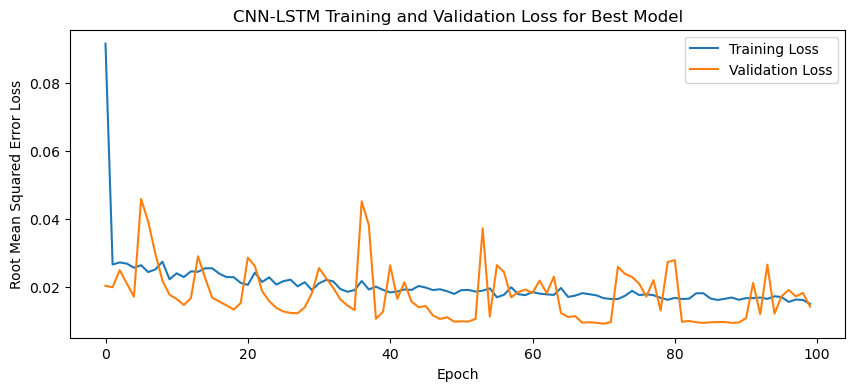

1/1 - 2s - loss: 0.0150 - 2s/epoch - 2s/step
Test Loss: 0.014959286898374557
1/1 [==============================] - 0s 86ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Specific Humidity\tPredicted Specific Humidity\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

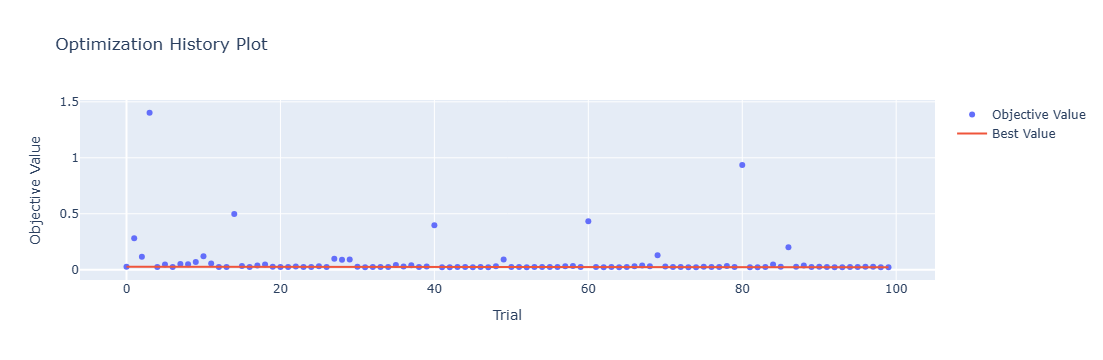

In [4]:
optuna.visualization.plot_optimization_history(study)

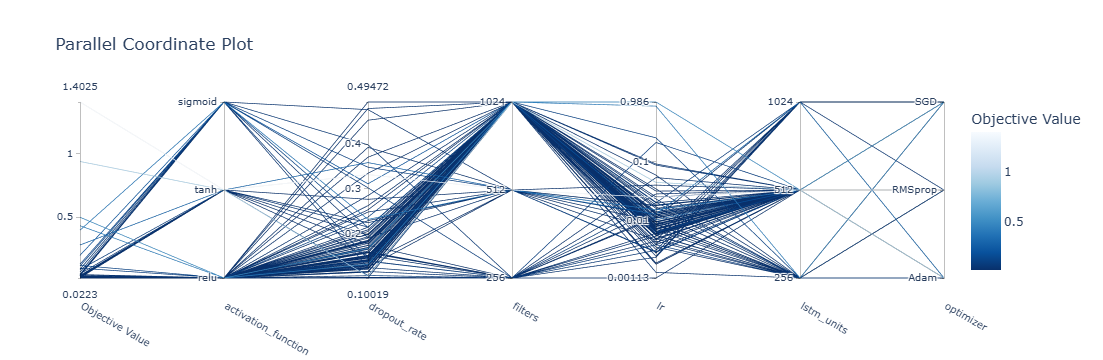

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

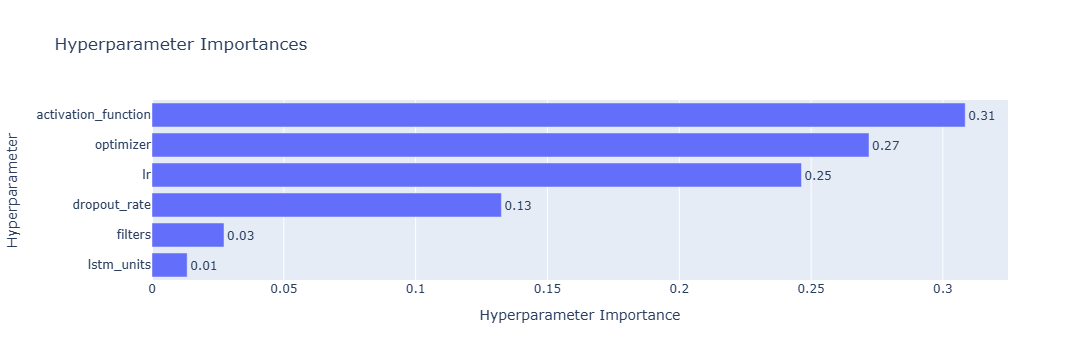

In [6]:
optuna.visualization.plot_param_importances(study)

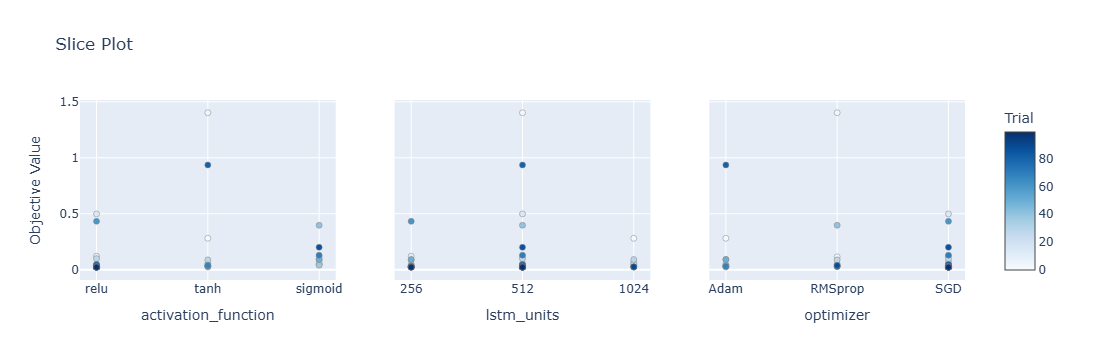

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

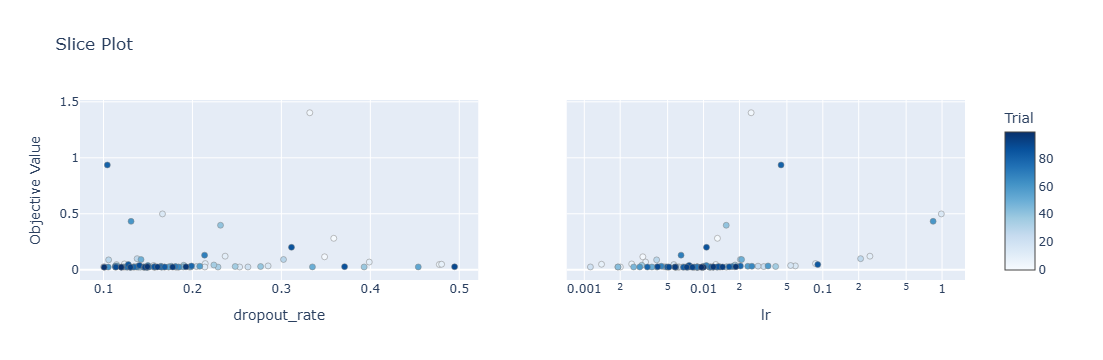

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 31s 164ms/step - loss: 0.0988 - accuracy: 0.0000e+00 - mae: 0.0988 - rmse: 0.0988 - mape: 19.8370 - pearson: nan - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mae: 0.0210 - val_rmse: 0.0210 - val_mape: 4.2333 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 81ms/step - loss: 0.0261 - accuracy: 0.0000e+00 - mae: 0.0261 - rmse: 0.0261 - mape: 5.2169 - pearson: nan - val_loss: 0.0249 - val_accuracy: 0.0000e+00 - val_mae: 0.0249 - val_rmse: 0.0249 - val_mape: 5.2700 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 7s 88ms/step - loss: 0.0272 - accuracy: 0.0000e+00 - mae: 0.0272 - rmse: 0.0272 - mape: 5.5015 - pearson: nan - val_loss: 0.0189 - val_accuracy: 0.0000e+00 - val_mae: 0.0189 - val_rmse: 0.0189 - val_mape: 3.9546 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 89ms/step - loss: 0.0264 - accuracy: 0.0000e+00 - mae: 0.0264 - rmse: 0.0264 - mape: 5.32

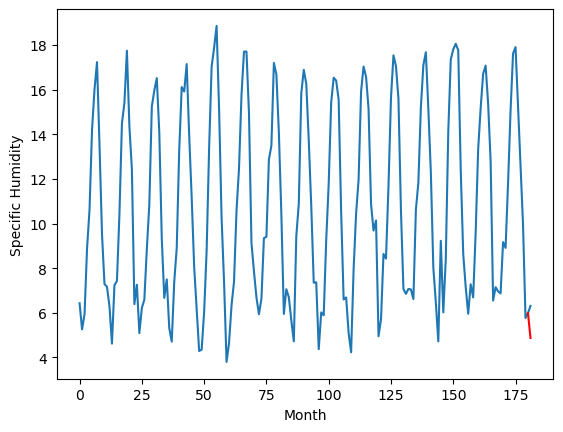

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		4.36		0.02
[180, 181]
[4.15, 4.357715718150139]


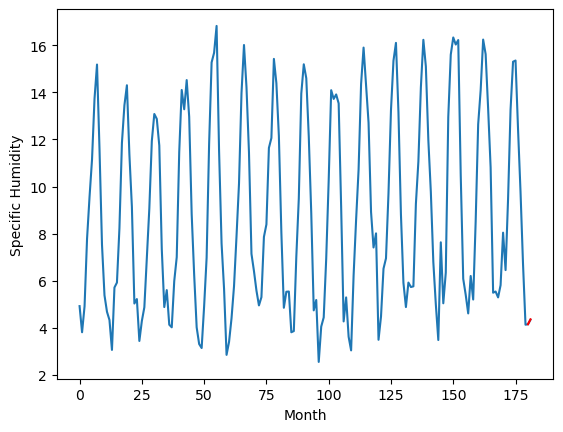

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		3.20		-0.02
[180, 181]
[5.12, 3.195293120741844]


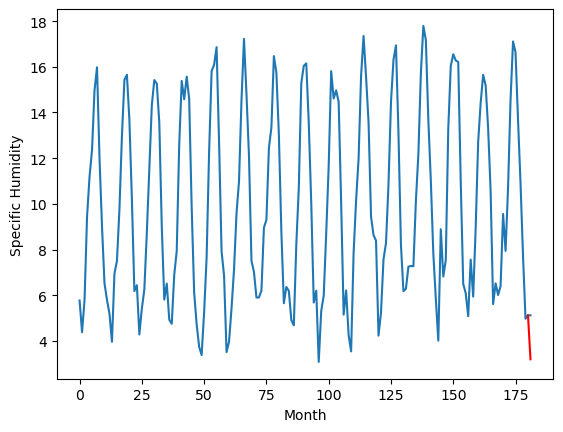

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.64		0.61
[180, 181]
[6.35, 2.641302193403244]


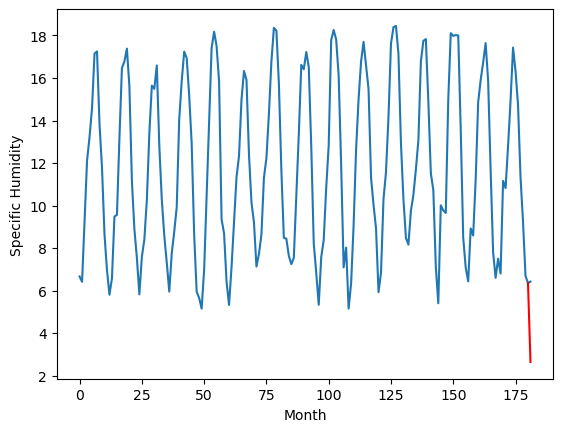

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.69		0.51
[180, 181]
[6.08, 6.690941118001938]


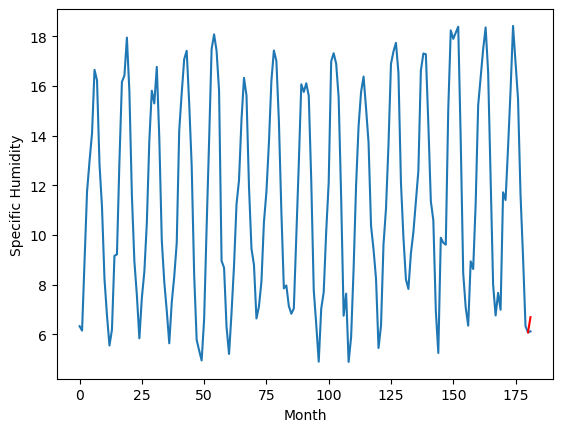

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		5.29		-0.46
[180, 181]
[3.92, 5.286657376289368]


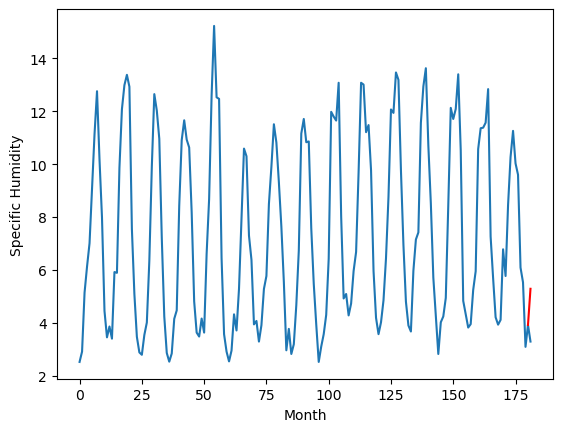

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.79		0.13
[180, 181]
[4.16, 5.787785398289561]


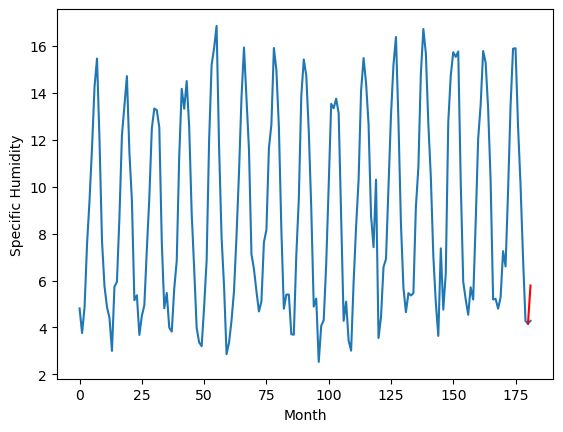

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.71		0.18
[180, 181]
[3.84, 6.709972649663687]


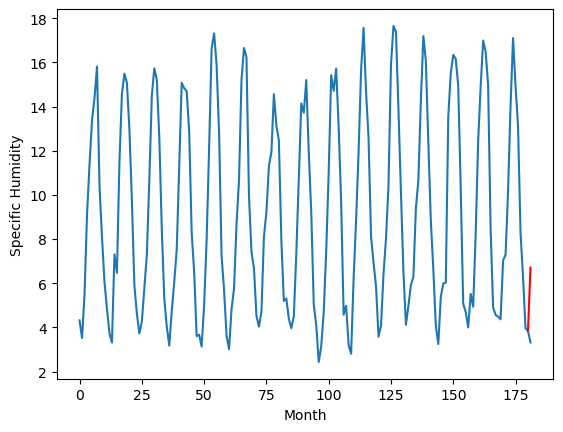

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.52		0.03
[180, 181]
[3.73, 6.523357840180397]


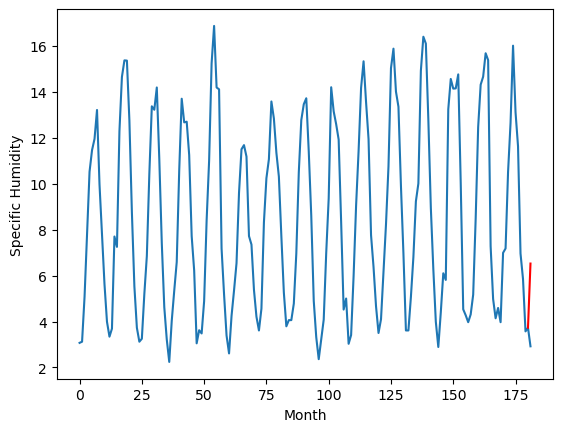

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.80		0.09
[180, 181]
[2.83, 2.8018053662776947]


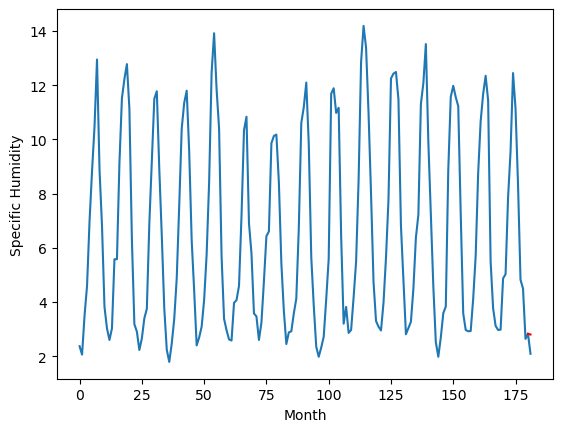

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.50		0.42
[180, 181]
[2.69, 4.501571056842804]


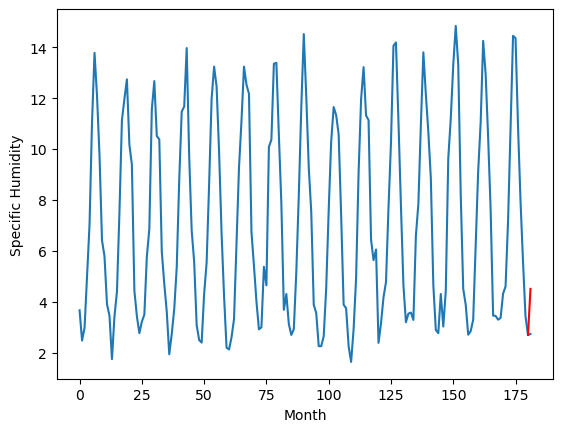

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.8739127567410465, 4.357715718150139, 3.195293120741844, 2.641302193403244, 6.690941118001938, 5.286657376289368, 5.787785398289561, 6.709972649663687, 6.523357840180397, 2.8018053662776947, 4.501571056842804]


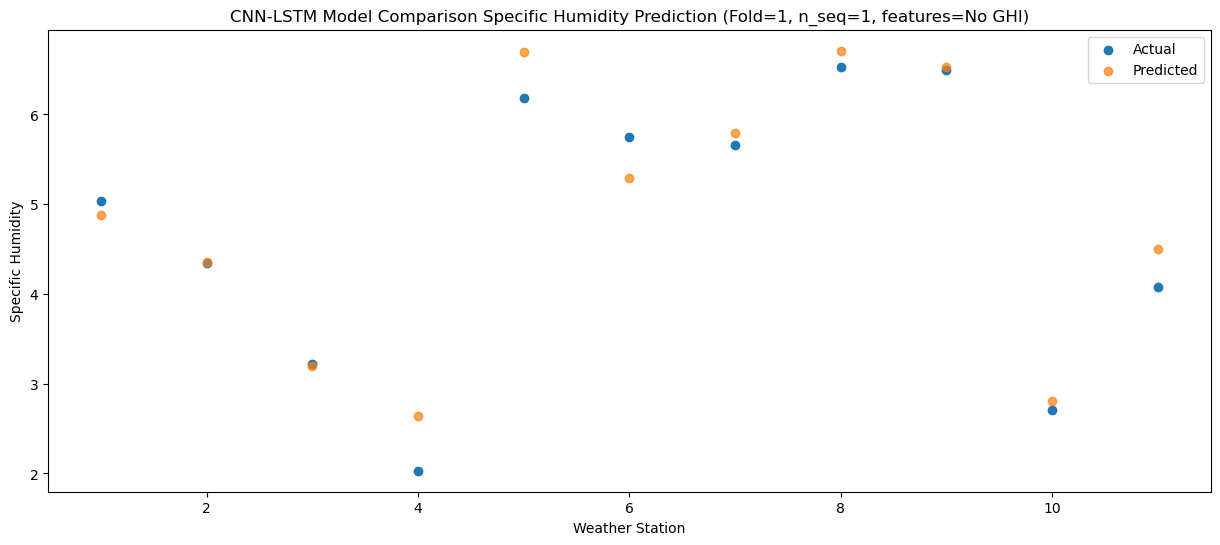

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 dropout_19 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_13 (LSTM)              (None, 512)               2099200   
                                                      

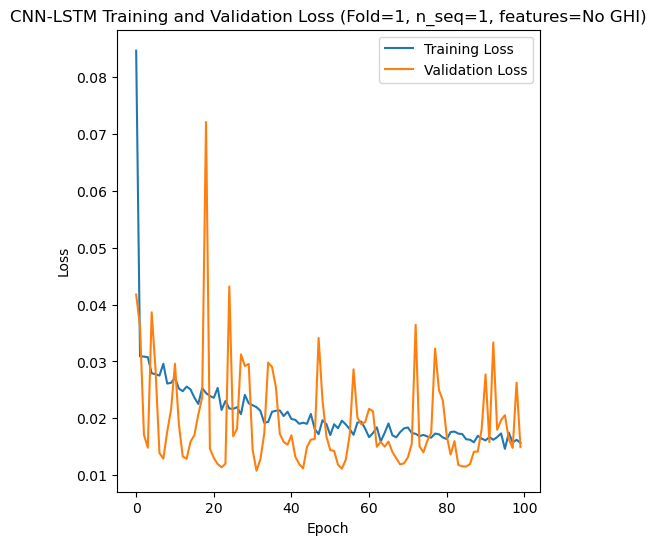

Epoch 1/100
84/84 [==============================] - 32s 155ms/step - loss: 0.0801 - accuracy: 0.0000e+00 - mae: 0.0801 - rmse: 0.0801 - mape: 16.2146 - pearson: nan - val_loss: 0.0280 - val_accuracy: 0.0000e+00 - val_mae: 0.0280 - val_rmse: 0.0280 - val_mape: 6.0045 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 72ms/step - loss: 0.0308 - accuracy: 0.0000e+00 - mae: 0.0308 - rmse: 0.0308 - mape: 6.1412 - pearson: nan - val_loss: 0.0152 - val_accuracy: 0.0000e+00 - val_mae: 0.0152 - val_rmse: 0.0152 - val_mape: 3.2910 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0297 - accuracy: 0.0000e+00 - mae: 0.0297 - rmse: 0.0297 - mape: 6.0129 - pearson: nan - val_loss: 0.0540 - val_accuracy: 0.0000e+00 - val_mae: 0.0540 - val_rmse: 0.0540 - val_mape: 11.4469 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 6s 68ms/step - loss: 0.0259 - accuracy: 0.0000e+00 - mae: 0.0259 - rmse: 0.0259 - mape: 5.1

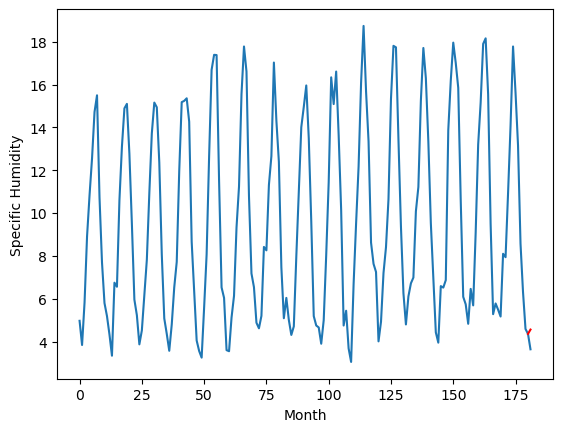

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		2.14		0.30
[180, 181]
[2.82, 2.1404112422466275]


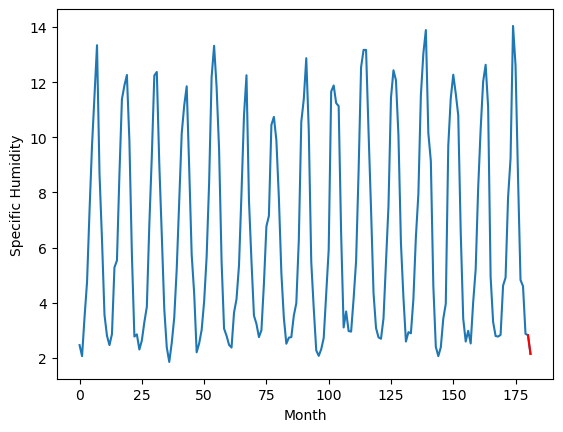

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		5.21		-0.32
[180, 181]
[9.16, 5.209558450579643]


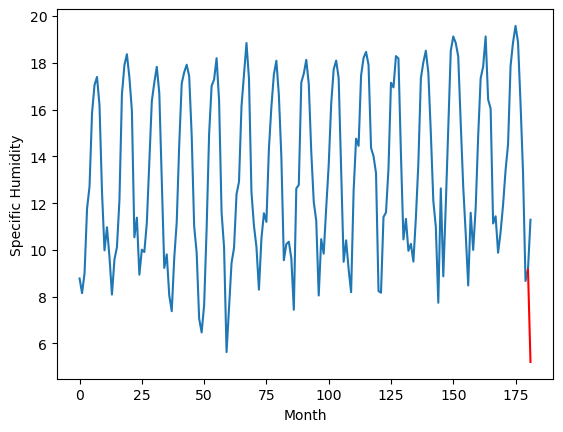

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.74		0.76
[180, 181]
[2.44, 4.73863330245018]


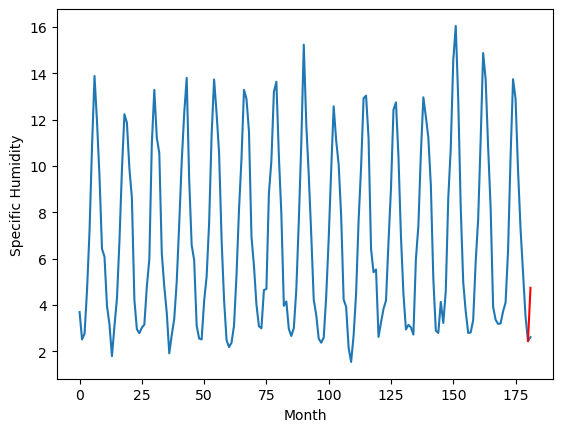

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		5.09		-0.01
[180, 181]
[6.65, 5.088171893060207]


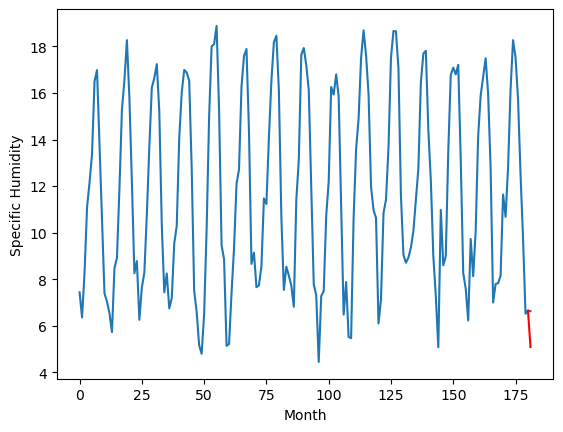

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.57		0.24
[180, 181]
[6.19, 2.571329033970833]


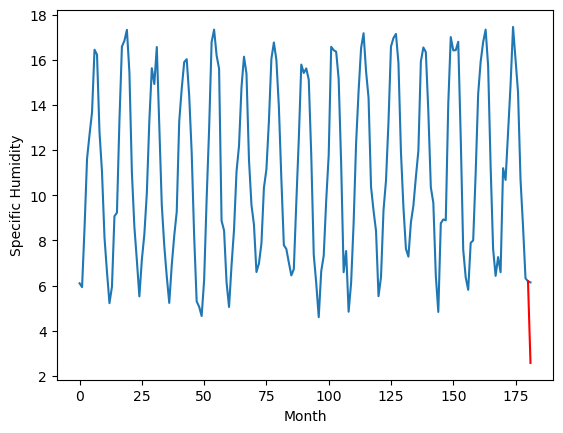

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.89		0.21
[180, 181]
[4.78, 8.89285488307476]


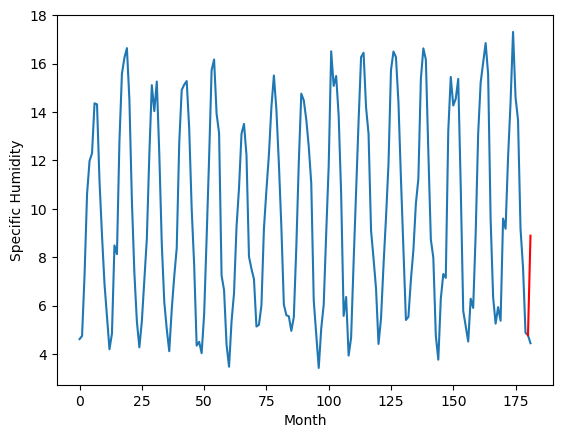

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		4.05		0.08
[180, 181]
[2.61, 4.045425685644149]


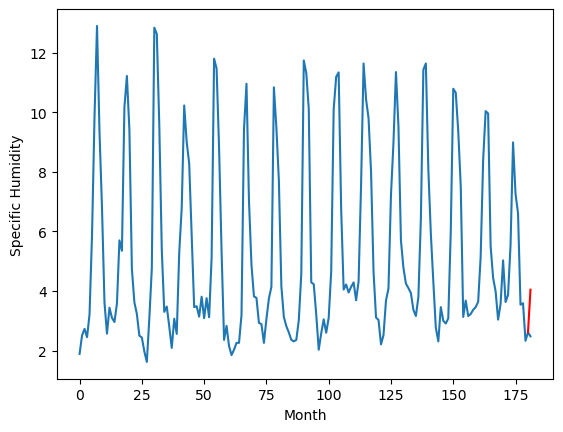

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.86		-0.43
[180, 181]
[4.6, 7.855423303842545]


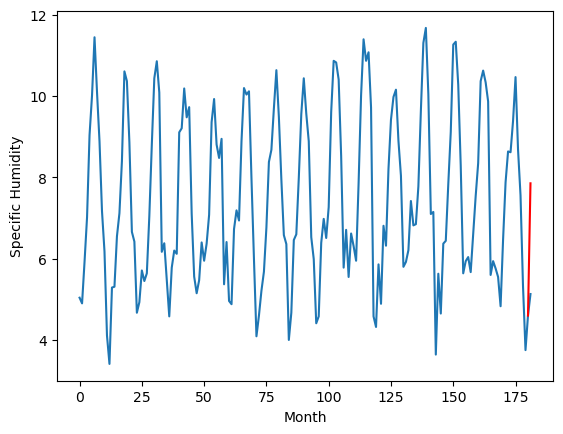

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.98		-0.00
[180, 181]
[4.27, 5.975253364443779]


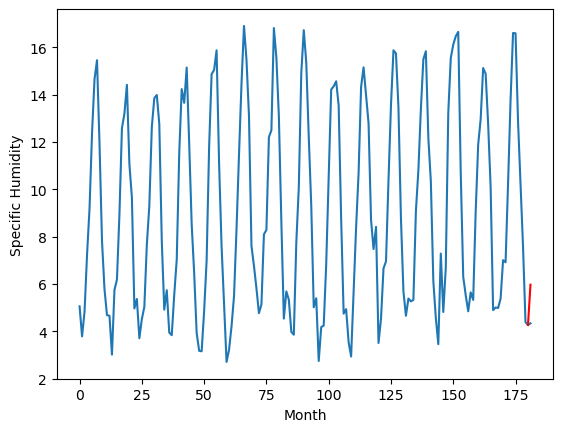

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.46		-0.17
[180, 181]
[3.91, 4.459882478117943]


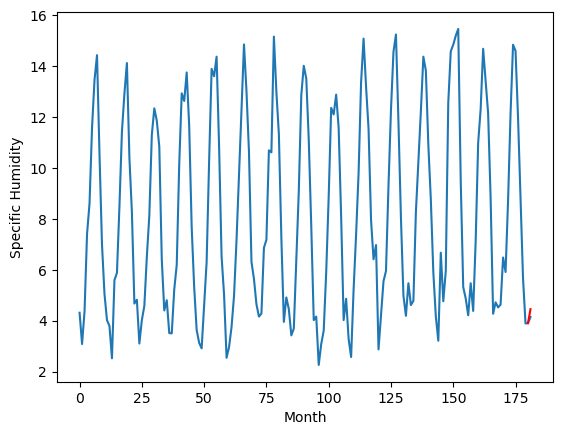

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.560800718963146, 2.1404112422466275, 5.209558450579643, 4.73863330245018, 5.088171893060207, 2.571329033970833, 8.89285488307476, 4.045425685644149, 7.855423303842545, 5.975253364443779, 4.459882478117943]


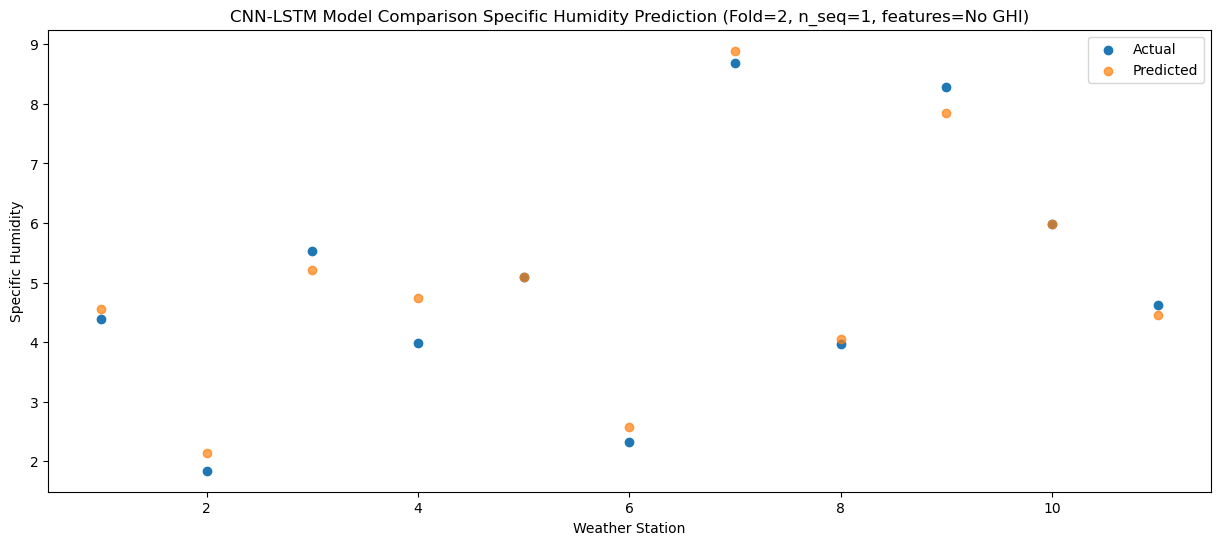

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 dropout_22 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_15 (LSTM)              (None, 512)               2099200   
                                                      

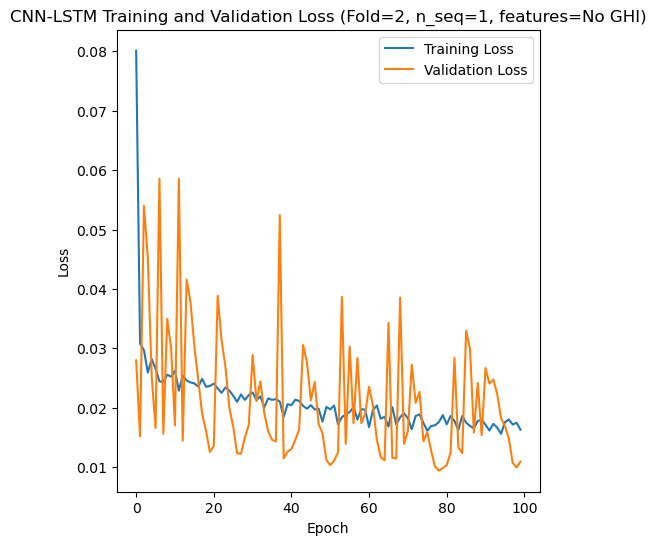

Epoch 1/100
84/84 [==============================] - 33s 137ms/step - loss: 0.0840 - accuracy: 0.0000e+00 - mae: 0.0840 - rmse: 0.0840 - mape: 17.2575 - pearson: nan - val_loss: 0.0222 - val_accuracy: 0.0000e+00 - val_mae: 0.0222 - val_rmse: 0.0222 - val_mape: 4.4197 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 69ms/step - loss: 0.0281 - accuracy: 0.0000e+00 - mae: 0.0281 - rmse: 0.0281 - mape: 5.7176 - pearson: nan - val_loss: 0.0180 - val_accuracy: 0.0000e+00 - val_mae: 0.0180 - val_rmse: 0.0180 - val_mape: 3.5088 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0287 - accuracy: 0.0000e+00 - mae: 0.0287 - rmse: 0.0287 - mape: 5.8443 - pearson: nan - val_loss: 0.0177 - val_accuracy: 0.0000e+00 - val_mae: 0.0177 - val_rmse: 0.0177 - val_mape: 3.3671 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - mae: 0.0247 - rmse: 0.0247 - mape: 5.01

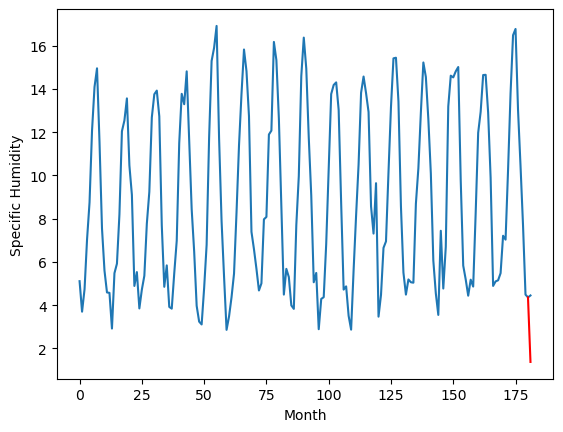

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.64		2.57		-0.07
[180, 181]
[3.43, 2.565990712046623]


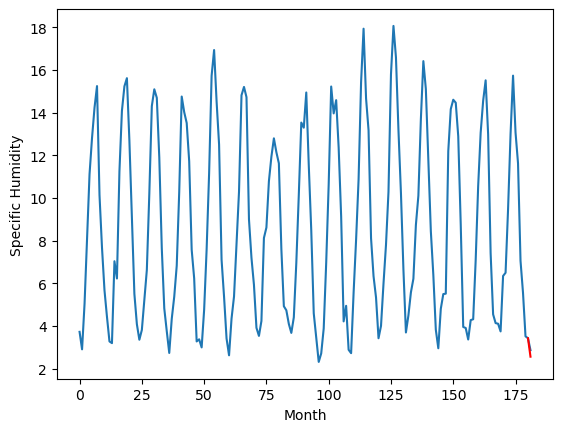

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.37		6.00		-0.37
[180, 181]
[5.43, 5.996309422254562]


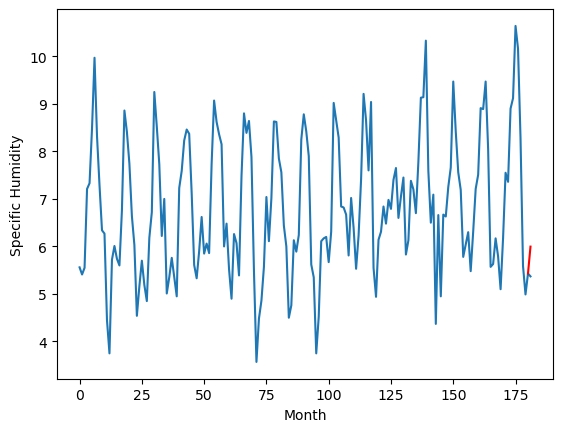

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.44		3.32		-0.12
[180, 181]
[3.21, 3.31582959651947]


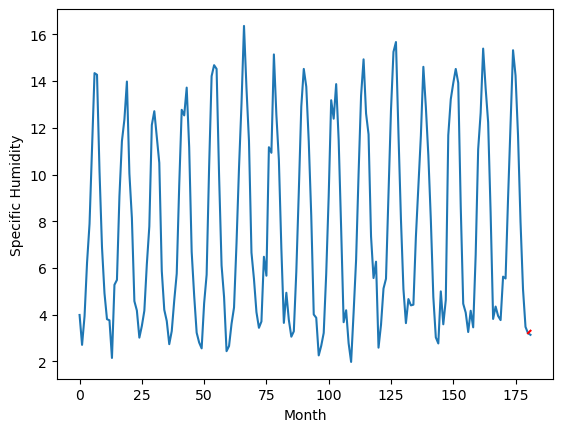

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.91		4.81		-0.10
[180, 181]
[3.04, 4.81034658908844]


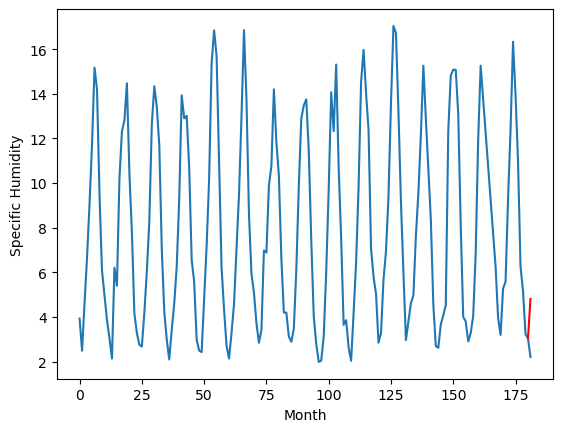

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.42		3.34		-0.08
[180, 181]
[2.91, 3.338187109231949]


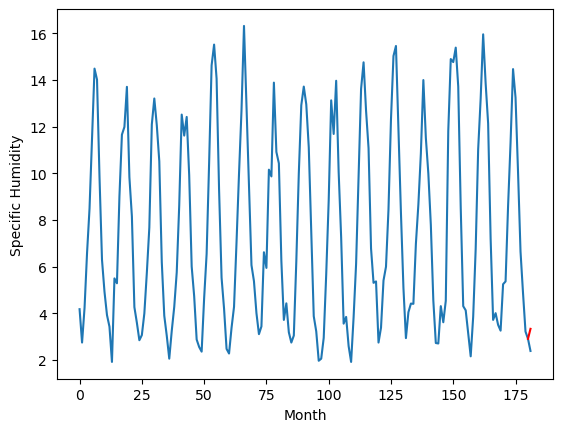

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.73		5.57		-0.16
[180, 181]
[1.6, 5.571227679438889]


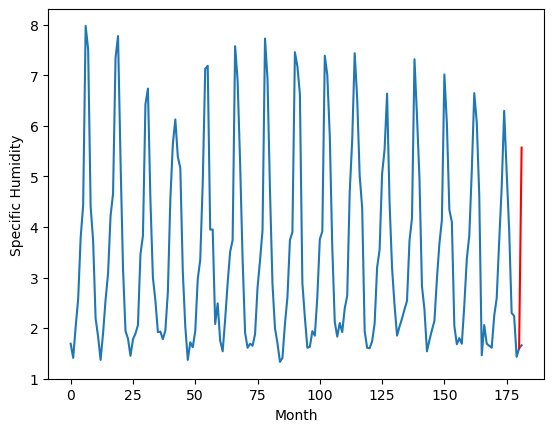

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.80		4.09		-0.71
[180, 181]
[2.86, 4.08716346859932]


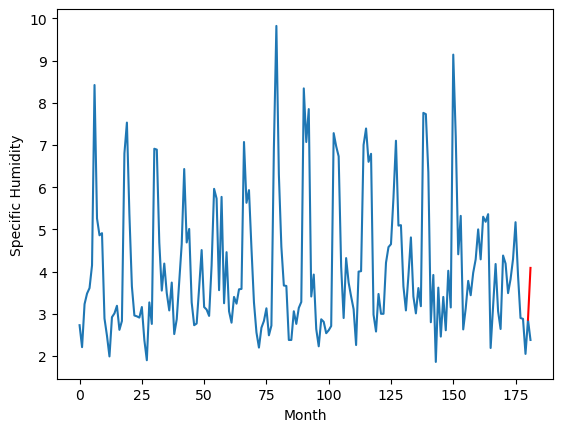

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.60		4.02		-0.58
[180, 181]
[5.65, 4.016289048194885]


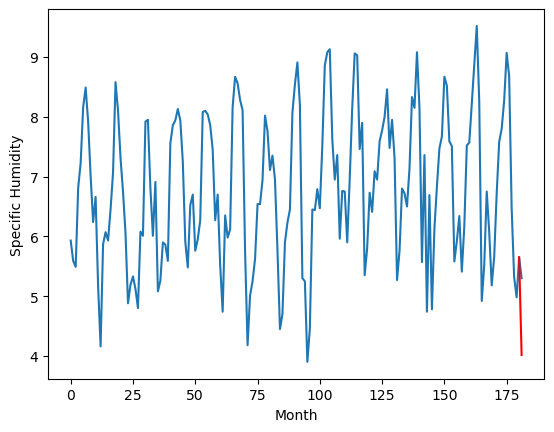

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.09		3.63		0.54
[180, 181]
[2.54, 3.6294338035583493]


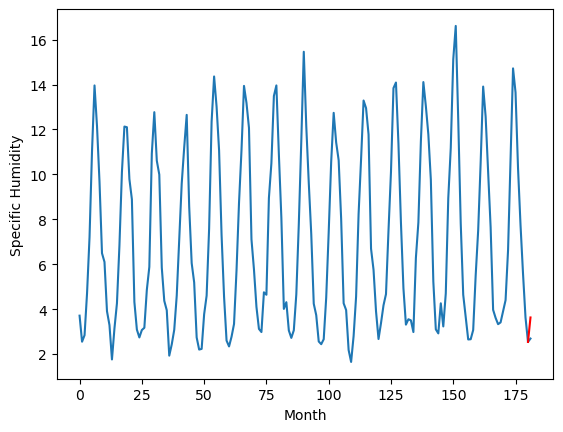

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.00		1.13		0.13
[180, 181]
[2.51, 1.132905604839325]


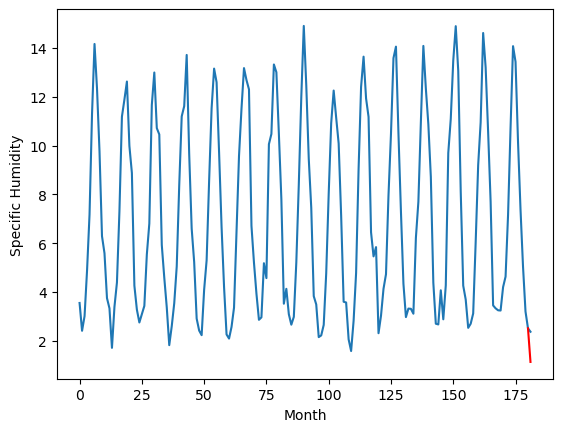

RangeIndex(start=1, stop=12, step=1)
[1.5600000000000005, 2.64, 6.369999999999998, 3.4399999999999995, 4.91, 3.42, 5.73, 4.800000000000001, 4.6, 3.09, 0.9999999999999993]
[1.3773481273651123, 2.565990712046623, 5.996309422254562, 3.31582959651947, 4.81034658908844, 3.338187109231949, 5.571227679438889, 4.08716346859932, 4.016289048194885, 3.6294338035583493, 1.132905604839325]


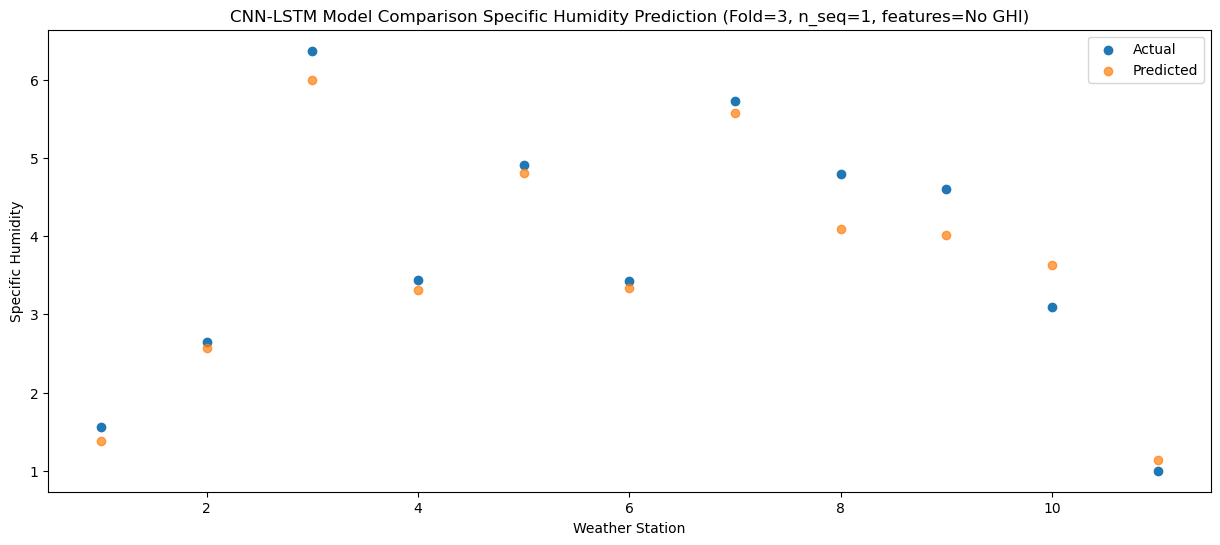

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 dropout_25 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_17 (LSTM)              (None, 512)               2099200   
                                                      

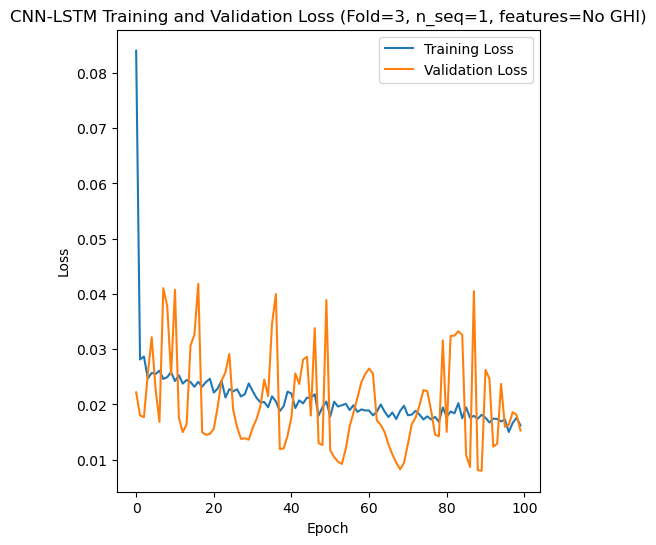

Epoch 1/100
84/84 [==============================] - 31s 138ms/step - loss: 0.0826 - accuracy: 0.0000e+00 - mae: 0.0826 - rmse: 0.0826 - mape: 16.7562 - pearson: nan - val_loss: 0.0214 - val_accuracy: 0.0000e+00 - val_mae: 0.0214 - val_rmse: 0.0214 - val_mape: 4.3237 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 68ms/step - loss: 0.0323 - accuracy: 0.0000e+00 - mae: 0.0323 - rmse: 0.0323 - mape: 6.4770 - pearson: nan - val_loss: 0.0349 - val_accuracy: 0.0000e+00 - val_mae: 0.0349 - val_rmse: 0.0349 - val_mape: 6.8380 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 5s 62ms/step - loss: 0.0310 - accuracy: 0.0000e+00 - mae: 0.0310 - rmse: 0.0310 - mape: 6.2862 - pearson: nan - val_loss: 0.0806 - val_accuracy: 0.0000e+00 - val_mae: 0.0806 - val_rmse: 0.0806 - val_mape: 16.4431 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0294 - accuracy: 0.0000e+00 - mae: 0.0294 - rmse: 0.0294 - mape: 5.9

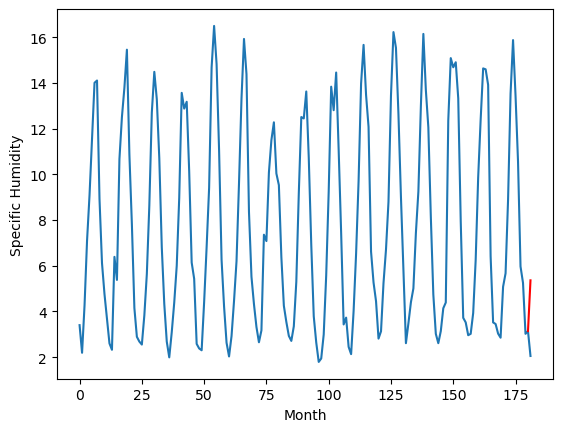

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		4.17		-0.10
[180, 181]
[7.79, 4.173280282020569]


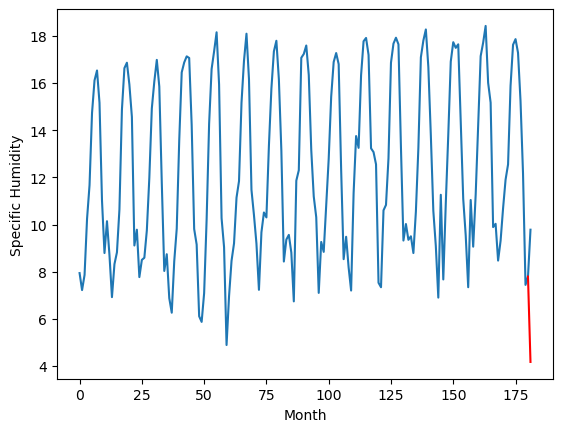

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		4.17		0.30
[180, 181]
[5.03, 4.171204816102982]


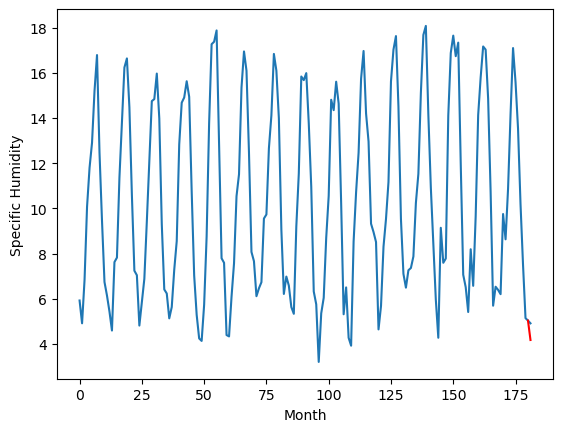

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		4.10		0.37
[180, 181]
[4.41, 4.0960975253582]


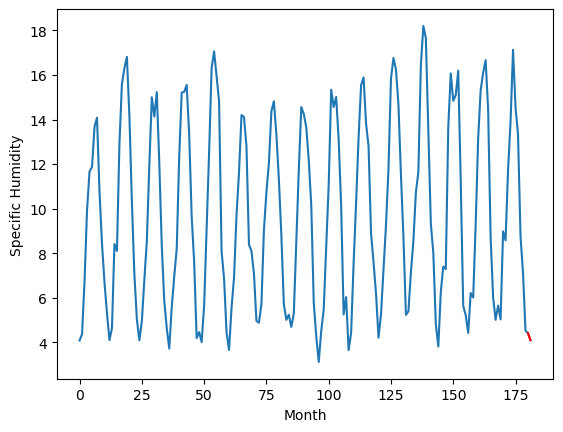

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		3.66		0.30
[180, 181]
[4.29, 3.664214664697647]


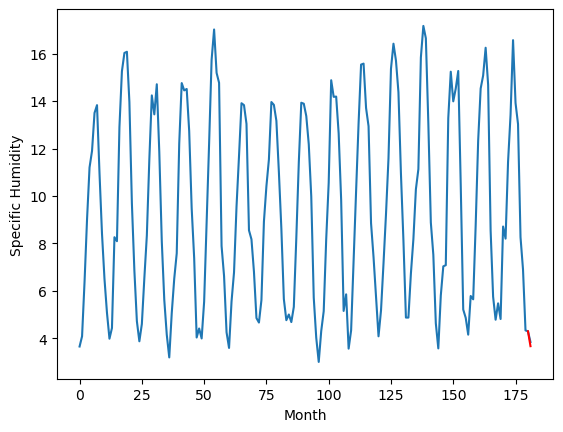

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		8.32		-0.32
[180, 181]
[3.47, 8.322724434137346]


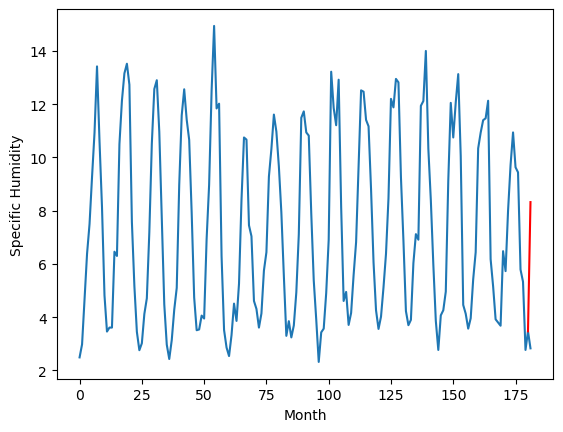

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.99		0.19
[180, 181]
[4.52, 5.98686919182539]


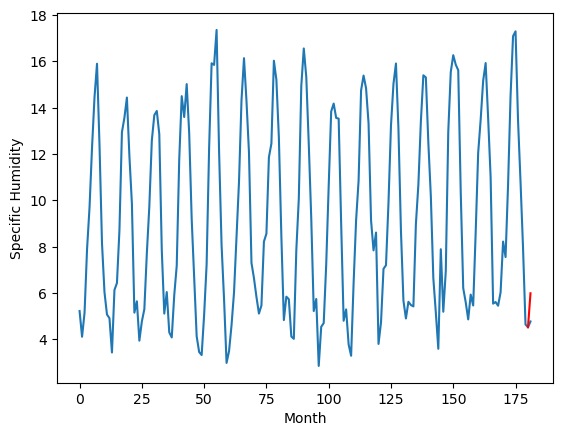

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		4.21		0.28
[180, 181]
[3.4, 4.205969871878624]


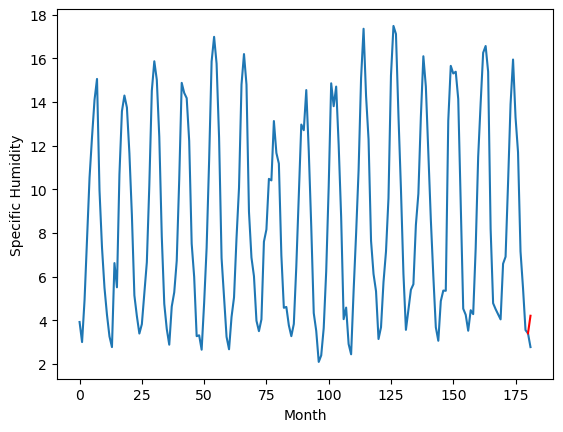

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.57		0.27
[180, 181]
[2.82, 3.5668731048703193]


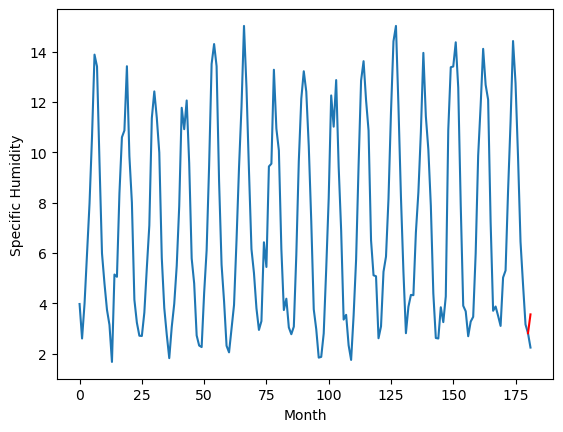

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		2.47		0.30
[180, 181]
[2.86, 2.4675486756116154]


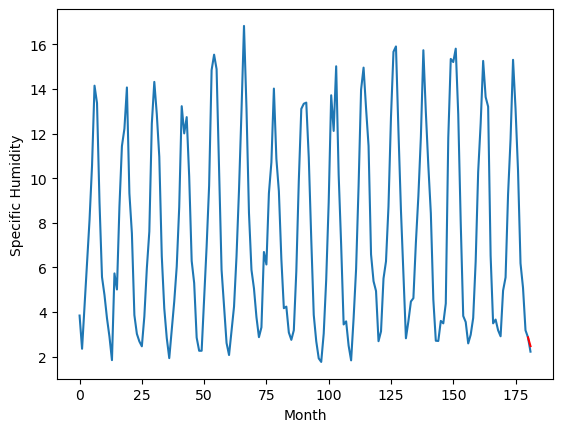

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		5.00		0.16
[180, 181]
[2.61, 4.999154241085052]


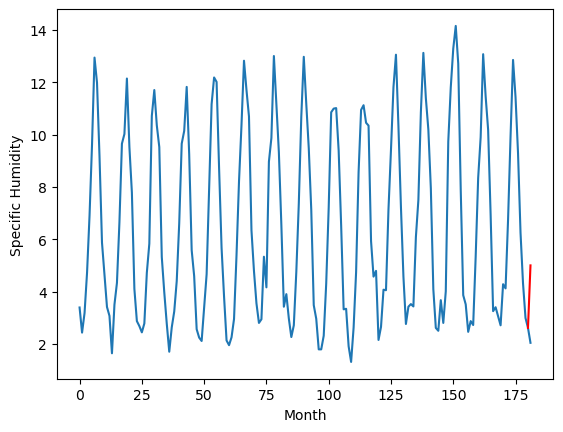

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[5.36184258878231, 4.173280282020569, 4.171204816102982, 4.0960975253582, 3.664214664697647, 8.322724434137346, 5.98686919182539, 4.205969871878624, 3.5668731048703193, 2.4675486756116154, 4.999154241085052]


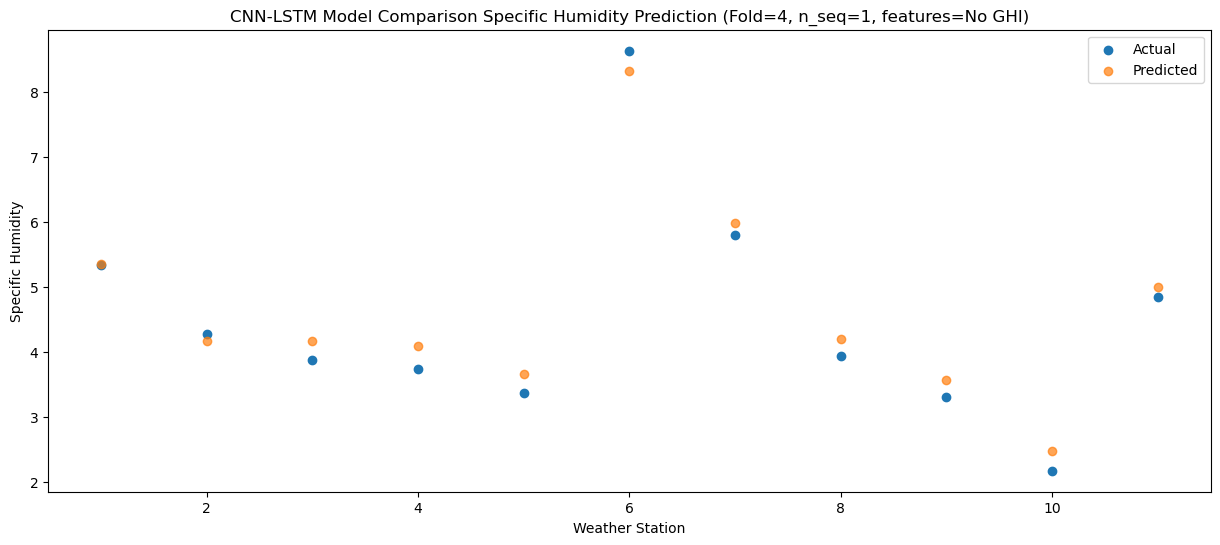

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 1024)           2017280   
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 dropout_28 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_19 (LSTM)              (None, 512)               2099200   
                                                      

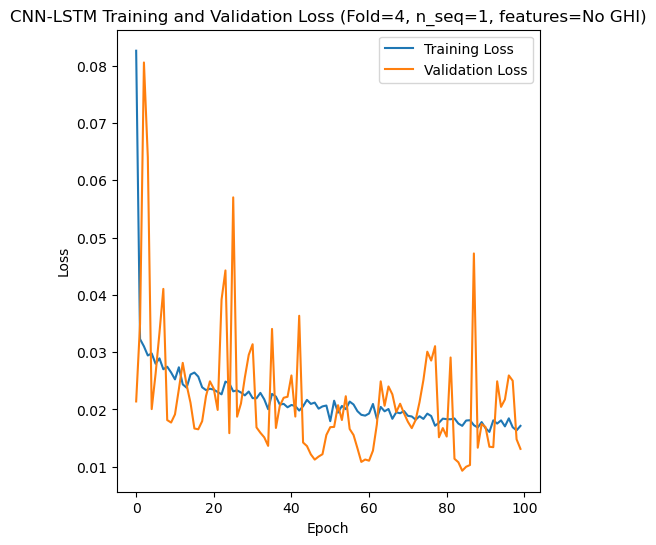

[[0.2511287868783179], [0.3177631304949711], [0.3197758196194403], [0.3558909362342816], [0.2565434385889064]]
[[0.21697626546702597], [0.23987164427610963], [0.2455604887550524], [0.2785134232416749], [0.23579726945947496]]
[[0.04027170996499307], [0.06360532707552462], [0.06273676826288868], [0.08133512320869342], [0.0621178580867723]]
[[0.9425082740194013], [0.9549600418655028], [0.9751889137737066], [0.9505556199372451], [0.9751908953833773]]
[[[4.907053918242455], [4.682622331380844], [4.460189797505737], [4.276422768235206], [5.563180997371673], [7.940043232142925], [5.427680748999119], [7.292427502870559], [4.574987762719393], [6.290170788764954], [4.607583329677582]], [[4.8739127567410465], [4.357715718150139], [3.195293120741844], [2.641302193403244], [6.690941118001938], [5.286657376289368], [5.787785398289561], [6.709972649663687], [6.523357840180397], [2.8018053662776947], [4.501571056842804]], [[4.560800718963146], [2.1404112422466275], [5.209558450579643], [4.738633302450

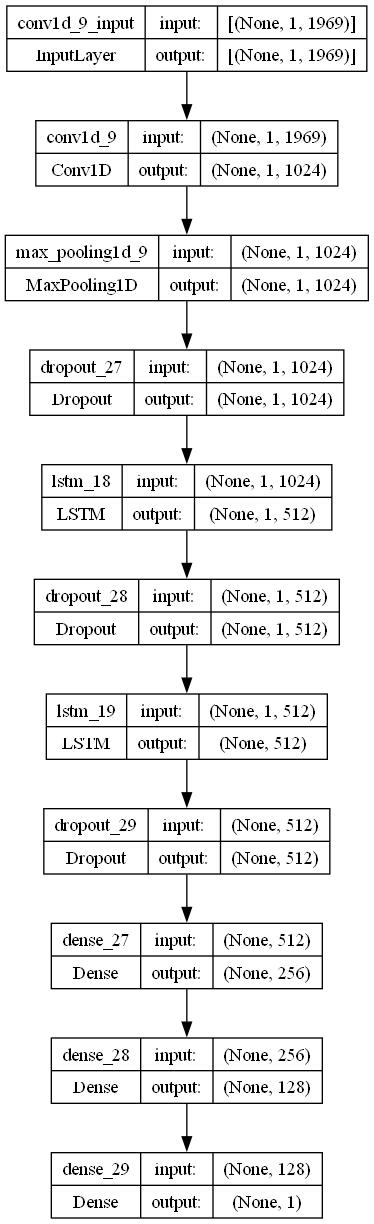

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.009777828608836353
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.1312852896295042

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    # Plotting the results
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['ws'], results_df['Actual'], label='Actual')
    plt.scatter(results_df['ws'], results_df['Predicted'], label='Predicted', alpha=0.7)
    title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No GHI)'
    plt.title(title1)
    plt.xlabel('Weather Station')
    plt.ylabel('Specific Humidity')
    plt.legend()
    plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)